## 引用 packages

In [ ]:
import pandas as pd
import re
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Concatenate, Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional, LSTM
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.layers import GRU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


## 讀入檔案

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CL/CL_final/data/final_all.csv', sep=',')
df.head()

,id,text,label,clean,positive,negative,negation,hyper,escape,length,entropy,first_single,first_plural,second_single,second_single_god,second_plural,third_single,third_plural,code_switch
0,0.0,"作詞：向月娥, 作曲：西樓, 編曲：鄭楠 / 西樓, 無辜的眼 迎風而張, 抱不住的孩子 揮...",sad,無辜 的 眼 迎風 而 張 抱不住 的 孩子 揮舞 著 手掌 被 ...,0.070423,0.209677,0.135593,0.05,0.0,0.221364,0.454060,0.000000,0.0,0.009091,0.0,0.0,0.000000,0.0,0.000000
1,1.0,"作詞：蔣蔣, 作曲：蔣蔣, 編曲：王柏鴻, 你怎麼還在做夢 哪家男神對你玩壁咚, 你早該換換...",happy,你 怎麼 還 在 做夢 哪 家 男神 對 你 玩 壁咚 你 早 該 換換 口...,0.112676,0.048387,0.067797,0.00,0.0,0.171171,0.412501,0.073684,0.0,0.100000,0.0,0.0,0.000000,0.0,0.000000
2,2.0,"廖偉志vs余秀娟, 作詞：廖偉志, 作曲：廖偉志, 女:你的愛 像沙漠的水, 解救命運的凌遲...",happy,廖偉志 vs 余秀娟 女 你 的 愛 像 沙漠 的 水 解救 命運 的 ...,0.042254,0.016129,0.016949,0.00,0.0,0.137709,0.403333,0.105263,0.0,0.072727,0.0,0.0,0.013889,0.0,0.005510
3,3.0,"作詞：李藝皓, 作曲：李藝皓, 是否你還會記得, 我多久沒聽說, 聽說別人講述你的經過, 我...",sad,是否 你 還 會 記得 我 多久 沒 聽說 聽說 別人 講述 你 的 經過 ...,0.028169,0.112903,0.305085,0.00,0.0,0.258687,0.608433,0.126316,0.0,0.172727,0.0,0.0,0.000000,0.0,0.000000
4,5.0,"電影 陪你很久很久 宣傳曲, 作詞：張傑, 作曲：張傑, 有顆星 獨自的 一直在閃爍, 那是...",sad,電影 陪 你 很 久 很 久 宣傳曲 有 顆 星 獨自 的 一直 在...,0.535211,0.112903,0.118644,0.10,0.0,0.436293,0.674573,0.263158,0.3,0.100000,0.0,0.0,0.000000,0.0,0.002755


## 把 disgust 和 angry 合併

In [ ]:
df['label'] = df['label'].replace('disgust', 'angry')

## 清理不小心標記到兩個的資料

In [ ]:
# Create a boolean mask to identify rows to be removed
mask = (df['label'] == 'angry#non') | (df['label'] == 'non#sad') | (df['label'] == 'surprise')| df['label'].isnull()

# Remove rows that satisfy the mask
df = df[~mask]

## Encoding

In [ ]:
desc = list(df['clean'])


In [ ]:
t = Tokenizer()
t.fit_on_texts(desc)

vocab_size = len(t.word_index) + 1
hashed_sents = t.texts_to_sequences(desc)
print(hashed_sents[0:5])

[[3991, 1, 178, 7981, 94, 627, 15886, 1, 793, 3807, 10, 2679, 58, 643, 1, 1537, 55, 10392, 22194, 10, 5334, 318, 4968, 2592, 1770, 4432, 8, 1356, 12, 16, 1, 1013, 908, 174, 1, 3352, 1173, 4, 382, 22195, 1, 1054, 71, 10, 1, 5693, 1, 166, 1, 12377, 714, 1, 32, 15887, 50, 1245, 1, 872, 616, 12378, 10, 3041, 715, 1, 217, 7, 1737, 200, 8, 112, 200, 8, 147, 369, 1, 3041, 466, 8, 89, 396, 55, 30, 60, 435, 3991, 1, 178, 7981, 94, 627, 15886, 1, 793, 3807, 10, 2679, 4682, 1, 1143, 55, 5694, 1418, 1, 982, 10, 2529, 1771, 607, 983, 1, 10393, 6097, 8, 1356, 275, 23, 1, 1284, 9079, 1, 7251, 67, 12379, 4, 1913, 1, 1374, 204, 1, 1042, 1, 166, 1, 12377, 714, 1, 32, 15887, 50, 1245, 1, 872, 616, 12378, 10, 3041, 715, 1, 217, 7, 1737, 64, 8, 112, 64, 8, 147, 466, 8, 112, 85, 3, 291, 734, 5, 132, 55, 222, 4, 6, 59, 1, 1275], [3, 74, 29, 7, 1869, 167, 215, 12380, 47, 3, 789, 22196, 3, 271, 125, 22197, 5695, 44, 2, 15888, 636, 10, 3992, 2, 1, 142, 56, 3, 10394, 22198, 15889, 1, 133, 6098, 6597, 3, 493, 221

In [ ]:
vocab_size

36353

In [ ]:
max_length = max([len(s.split()) for s in desc])
print(max_length)

924


In [ ]:
padded_sents = pad_sequences(hashed_sents, maxlen=max_length, padding='post')
print(padded_sents[0:5])

[[ 3991     1   178 ...     0     0     0]
 [    3    74    29 ...     0     0     0]
 [15892 15893 22207 ...     0     0     0]
 [  151     3    29 ...     0     0     0]
 [  769    92     3 ...     0     0     0]]


## 自製的 lyrics embeddings

In [ ]:

embeddings_index_ly = dict()

with open('/content/drive/MyDrive/CL/CL_final/data/word_embeddings.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index_ly[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index_ly))

Loaded 264219 word vectors.


In [ ]:
# create a weight matrix for words in training docs

embedding_matrix_ly = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index_ly.get(word)
    if embedding_vector is not None:
        embedding_matrix_ly[i] = embedding_vector

## CKIP 的 embeddings

In [ ]:

embeddings_index = dict()

with open('/content/drive/MyDrive/CL/CL_final/data/Glove_CNA_ASBC_300d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 517015 word vectors.


In [ ]:
# create a weight matrix for words in training docs

embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Training

In [ ]:

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the labels to integer values
encoded_labels = label_encoder.fit_transform(df['label'])


# # Convert the encoded labels to one-hot encoded format
labels = to_categorical(encoded_labels, num_classes=5)


# Convert the columns to array
handcrafted_features = df[['positive', 'negative', 'length', 'hyper', 'escape', 'entropy', 'first_plural', 'third_single', 'third_plural', 'code_switch']].to_numpy()
# df[['positive', 'negative', 'length', 'hyper', 'escape', 'entropy', 'first_plural', 'third_single', 'third_plural', 'code_switch']].to_numpy()
# df.iloc[:, 4:].to_numpy()
# df[['negation', 'entropy']].to_numpy()

#### shuffle data 並區分 training and test set

In [ ]:
# Split the data into train and test sets
feature_train, feature_test, adfeature_train, adfeature_test, label_train, label_test = train_test_split(
    padded_sents, handcrafted_features, labels, test_size=0.2, random_state=612)

## BiLSTM Model Training

### Lyrics Embeddings only

In [ ]:


modelE = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_ly], input_length=max_length, trainable=False)
modelE.add(e)
modelE.add(Bidirectional(LSTM(64)))  # BiLSTM layer
modelE.add(Dense(5, activation='softmax'))  # softmax activation

# compile the model
modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
print(modelE.summary())
modelE.fit(feature_train, label_train, epochs=50, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 924, 300)          10905900  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 11,093,425
Trainable params: 187,525
Non-trainable params: 10,905,900
_________________________________________________________________
None
Epoch 1/50
89/89 [==============================] - 13s 79ms/step - loss: 1.4062 - accuracy: 0.3874
Epoch 2/50
89/89 [==============================] - 6s 63ms/step - loss: 1.3363 - accuracy: 0.4184
Epoch 3/50
89/89 [============

In [ ]:
# model evaluation
loss, accuracy = modelE.evaluate(feature_test, np.array(label_test), verbose=0)
print('Accuracy: %f' % (accuracy * 100))
print('Loss: %f' % loss)

Accuracy: 40.563381
Loss: 3.296862


In [ ]:
# Make predictions

predictions = modelE.predict(feature_test)
predicted_labels = np.argmax(predictions, axis=1)

23/23 [==============================] - 2s 33ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:
for label, word in zip(unique_labels, words):
    print(f"Numerical label: {label}, Word: {word}")

Numerical label: 0, Word: angry
Numerical label: 1, Word: fear
Numerical label: 2, Word: happy
Numerical label: 3, Word: non
Numerical label: 4, Word: sad


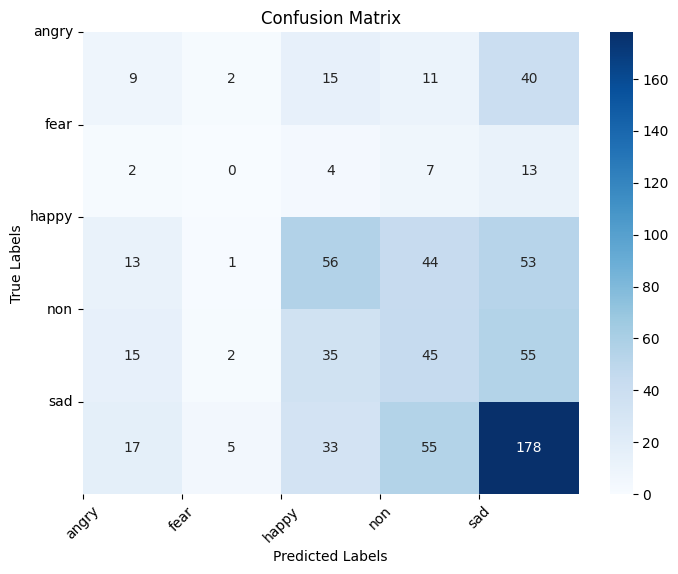

In [ ]:


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['angry','fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportE = classification_report(true_labels, predicted_labels, target_names = class_names)

# Print the classification report
print(reportE)


              precision    recall  f1-score   support

       angry       0.16      0.12      0.14        77
        fear       0.00      0.00      0.00        26
       happy       0.39      0.34      0.36       167
         non       0.28      0.30      0.29       152
         sad       0.53      0.62      0.57       288

    accuracy                           0.41       710
   macro avg       0.27      0.27      0.27       710
weighted avg       0.38      0.41      0.39       710



### CKIP Embeddings only

In [ ]:


modelE = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
modelE.add(e)
modelE.add(Bidirectional(LSTM(64)))  # BiLSTM layer
modelE.add(Dense(5, activation='softmax'))  # softmax activation

# compile the model
modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
print(modelE.summary())
modelE.fit(feature_train, label_train, epochs=50, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 924, 300)          10905900  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 11,093,425
Trainable params: 187,525
Non-trainable params: 10,905,900
_________________________________________________________________
None
Epoch 1/50
89/89 [==============================] - 15s 56ms/step - loss: 1.3798 - accuracy: 0.4078
Epoch 2/50
89/89 [==============================] - 6s 62ms/step - loss: 1.3248 - accuracy: 0.4276
Epoch 3/50
89/89 [============

In [ ]:
# model evaluation
loss, accuracy = modelE.evaluate(feature_test, np.array(label_test), verbose=0)
print('Accuracy: %f' % (accuracy * 100))
print('Loss: %f' % loss)

Accuracy: 52.816904
Loss: 3.317112


In [ ]:
# Make predictions

predictions = modelE.predict(feature_test)
predicted_labels = np.argmax(predictions, axis=1)

23/23 [==============================] - 1s 23ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:
for label, word in zip(unique_labels, words):
    print(f"Numerical label: {label}, Word: {word}")

Numerical label: 0, Word: angry
Numerical label: 1, Word: fear
Numerical label: 2, Word: happy
Numerical label: 3, Word: non
Numerical label: 4, Word: sad


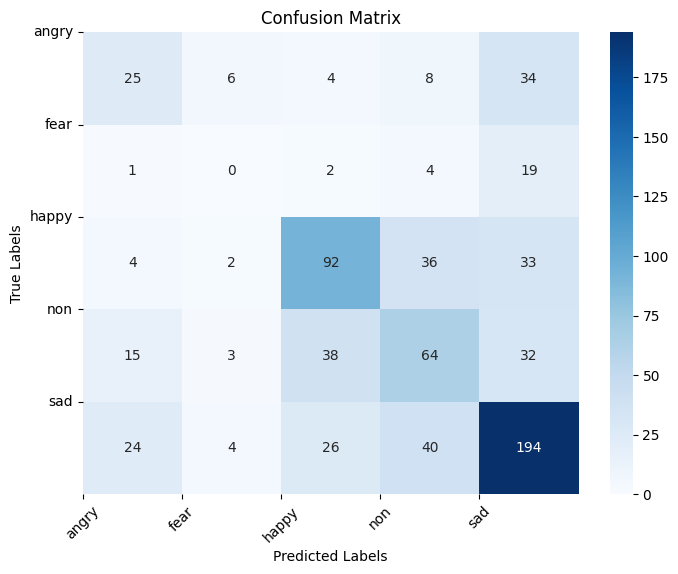

In [ ]:


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['angry','fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportE = classification_report(true_labels, predicted_labels, target_names = class_names)

# Print the classification report
print(reportE)


              precision    recall  f1-score   support

       angry       0.36      0.32      0.34        77
        fear       0.00      0.00      0.00        26
       happy       0.57      0.55      0.56       167
         non       0.42      0.42      0.42       152
         sad       0.62      0.67      0.65       288

    accuracy                           0.53       710
   macro avg       0.39      0.39      0.39       710
weighted avg       0.52      0.53      0.52       710



### Features only

In [ ]:
from tensorflow.keras.layers import Input, concatenate, Reshape, LSTM, Dense
from tensorflow.keras.models import Model

# Define input layers
text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(15,))

# Define the LSTM layer for text inputs
layer = Reshape((max_length, 1))(text_inputs)
layer = LSTM(64, return_sequences=True)(layer)

# Flatten the LSTM output
layer = Reshape((-1,))(layer)

# Concatenate the LSTM output with the additional feature input
layer = concatenate([layer, feature_input])

# Reshape the layer
layer = Reshape((layer.shape[1], 1))(layer)

# Apply another LSTM layer
layer = LSTM(64)(layer)

# Add a dense layer
layer = Dense(64, activation='relu')(layer)

# Output layer
output = Dense(5, activation='softmax')(layer)

# Define the model
modelE = Model(inputs=[text_inputs, feature_input], outputs=output)
modelE.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelE.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 924, 1)       0           ['input[0][0]']                  
                                                                                                  
 lstm (LSTM)                    (None, 924, 64)      16896       ['reshape[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 59136)        0           ['lstm[0][0]']                   
                                                                                              

In [ ]:
modelE.fit([feature_train, adfeature_train], label_train, epochs=50, batch_size=32)

Epoch 1/50
89/89 [==============================] - 138s 1s/step - loss: 1.4438 - accuracy: 0.3980
Epoch 2/50
89/89 [==============================] - 127s 1s/step - loss: 1.3959 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 127s 1s/step - loss: 1.3917 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 128s 1s/step - loss: 1.3908 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 128s 1s/step - loss: 1.3913 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 127s 1s/step - loss: 1.3892 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 131s 1s/step - loss: 1.3884 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 127s 1s/step - loss: 1.3876 - accuracy: 0.3980
Epoch 9/50
89/89 [==============================] - 128s 1s/step - loss: 1.3801 - accuracy: 0.3987
Epoch 10/50
89/89 [==============================] - 126s 1s/step - loss: 1.3770 - accuracy: 0.3987
Epoch 11/

In [ ]:

# Evaluate the model
loss, accuracy = modelE.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 41.97%
Loss: 1.3458


In [ ]:
# Make predictions

predictionsE = modelE.predict([feature_test, adfeature_test])
predicted_labelsE = np.argmax(predictionsE, axis=1)

23/23 [==============================] - 19s 804ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:
for label, word in zip(unique_labels, words):
    print(f"Numerical label: {label}, Word: {word}")

Numerical label: 0, Word: angry
Numerical label: 1, Word: fear
Numerical label: 2, Word: happy
Numerical label: 3, Word: non
Numerical label: 4, Word: sad


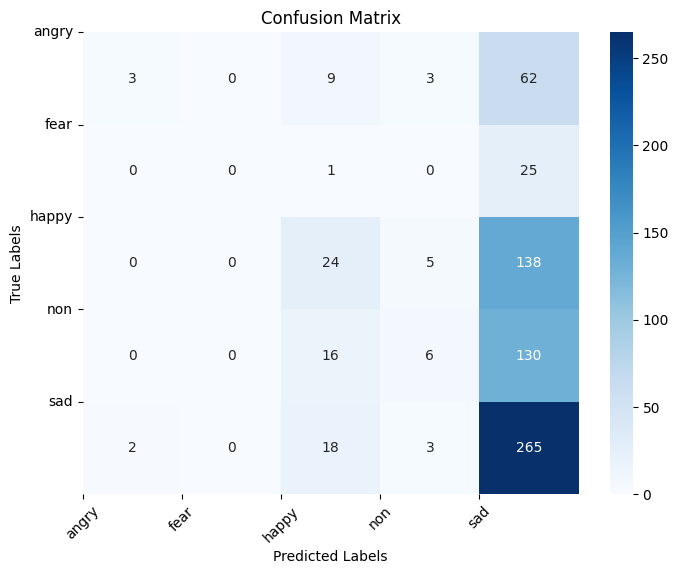

In [ ]:


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labelsE)
class_names = ['angry','fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportE = classification_report(true_labels, predicted_labelsE, target_names = class_names)

# Print the classification report
print(reportE)


              precision    recall  f1-score   support

       angry       0.60      0.04      0.07        77
        fear       0.00      0.00      0.00        26
       happy       0.35      0.14      0.20       167
         non       0.35      0.04      0.07       152
         sad       0.43      0.92      0.58       288

    accuracy                           0.42       710
   macro avg       0.35      0.23      0.19       710
weighted avg       0.40      0.42      0.31       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Embeddings + Features

#### Positive

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 128)         186880      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 27s 220ms/step - loss: 1.4260 - accuracy: 0.3927
Epoch 2/50
89/89 [==============================] - 17s 193ms/step - loss: 1.3823 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 176ms/step - loss: 1.3351 - accuracy: 0.4043
Epoch 4/50
89/89 [==============================] - 14s 156ms/step - loss: 1.1564 - accuracy: 0.4917
Epoch 5/50
89/89 [==============================] - 14s 157ms/step - loss: 0.8415 - accuracy: 0.6486
Epoch 6/50
89/89 [==============================] - 12s 138ms/step - loss: 0.5796 - accuracy: 0.7970
Epoch 7/50
89/89 [==============================] - 11s 125ms/step - loss: 0.3267 - accuracy: 0.8964
Epoch 8/50
89/89 [==============================] - 11s 119ms/step - loss: 0.1951 - accuracy: 0.9376
Epoch 9/50
89/89 [==============================] - 10s 109ms/step - loss: 0.1235 - accuracy: 0.9556
Epoch 10/50
89/89 [==============================] - 9s 97ms/step - loss: 0.0937 - accuracy

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 41.97%
Loss: 7.8754


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

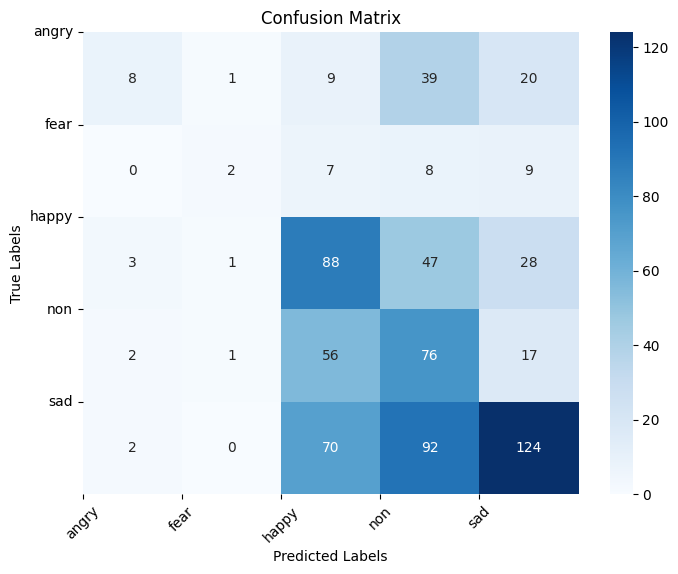

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.53      0.10      0.17        77
        fear       0.40      0.08      0.13        26
       happy       0.38      0.53      0.44       167
         non       0.29      0.50      0.37       152
         sad       0.63      0.43      0.51       288

    accuracy                           0.42       710
   macro avg       0.45      0.33      0.32       710
weighted avg       0.48      0.42      0.41       710



In [ ]:
# Get the weights of the last layer
weights = model.layers[-1].get_weights()[0]

# Calculate feature importance
feature_importance = np.abs(weights[:-5]).sum(axis=0) / np.abs(weights[:-5]).sum()

feature_importance

array([0.19064783, 0.17881714, 0.21118522, 0.1876639 , 0.23168594],
      dtype=float32)

#### Negative

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 128)         186880      ['embedding_8[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 30s 222ms/step - loss: 1.4362 - accuracy: 0.3863
Epoch 2/50
89/89 [==============================] - 19s 210ms/step - loss: 1.3850 - accuracy: 0.3973
Epoch 3/50
89/89 [==============================] - 16s 183ms/step - loss: 1.3386 - accuracy: 0.4332
Epoch 4/50
89/89 [==============================] - 13s 145ms/step - loss: 1.0726 - accuracy: 0.5587
Epoch 5/50
89/89 [==============================] - 11s 124ms/step - loss: 0.7422 - accuracy: 0.7011
Epoch 6/50
89/89 [==============================] - 12s 140ms/step - loss: 0.5215 - accuracy: 0.8153
Epoch 7/50
89/89 [==============================] - 11s 121ms/step - loss: 0.2386 - accuracy: 0.9274
Epoch 8/50
89/89 [==============================] - 13s 144ms/step - loss: 0.1264 - accuracy: 0.9563
Epoch 9/50
89/89 [==============================] - 10s 119ms/step - loss: 0.0812 - accuracy: 0.9718
Epoch 10/50
89/89 [==============================] - 10s 107ms/step - loss: 0.0663 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 33.24%
Loss: 7.7087


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

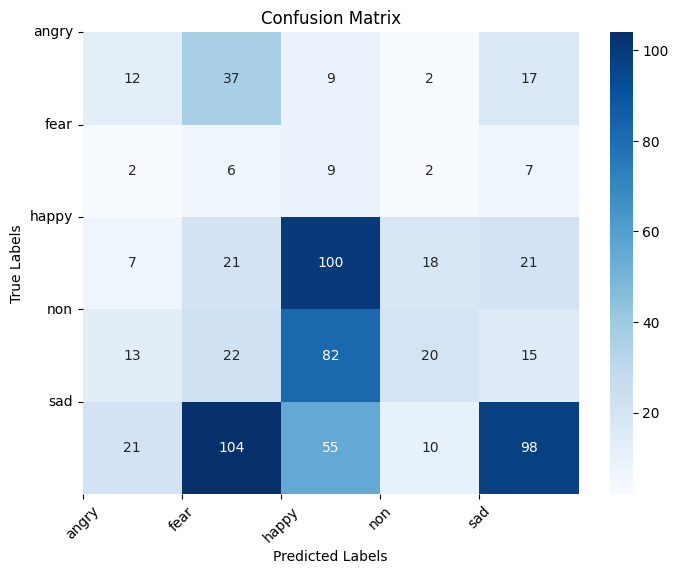

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.22      0.16      0.18        77
        fear       0.03      0.23      0.06        26
       happy       0.39      0.60      0.47       167
         non       0.38      0.13      0.20       152
         sad       0.62      0.34      0.44       288

    accuracy                           0.33       710
   macro avg       0.33      0.29      0.27       710
weighted avg       0.45      0.33      0.35       710



#### Negation

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 128)         186880      ['embedding_8[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 33s 225ms/step - loss: 1.4314 - accuracy: 0.3927
Epoch 2/50
89/89 [==============================] - 18s 204ms/step - loss: 1.3768 - accuracy: 0.3983
Epoch 3/50
89/89 [==============================] - 15s 164ms/step - loss: 1.2761 - accuracy: 0.4374
Epoch 4/50
89/89 [==============================] - 15s 167ms/step - loss: 0.9900 - accuracy: 0.6059
Epoch 5/50
89/89 [==============================] - 13s 145ms/step - loss: 0.7053 - accuracy: 0.7300
Epoch 6/50
89/89 [==============================] - 14s 153ms/step - loss: 0.5179 - accuracy: 0.8019
Epoch 7/50
89/89 [==============================] - 12s 135ms/step - loss: 0.3702 - accuracy: 0.8537
Epoch 8/50
89/89 [==============================] - 11s 122ms/step - loss: 0.3286 - accuracy: 0.8608
Epoch 9/50
89/89 [==============================] - 9s 99ms/step - loss: 0.2937 - accuracy: 0.8872
Epoch 10/50
89/89 [==============================] - 10s 114ms/step - loss: 0.2459 - accuracy

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 29.72%
Loss: 9.5688


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 3s 37ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

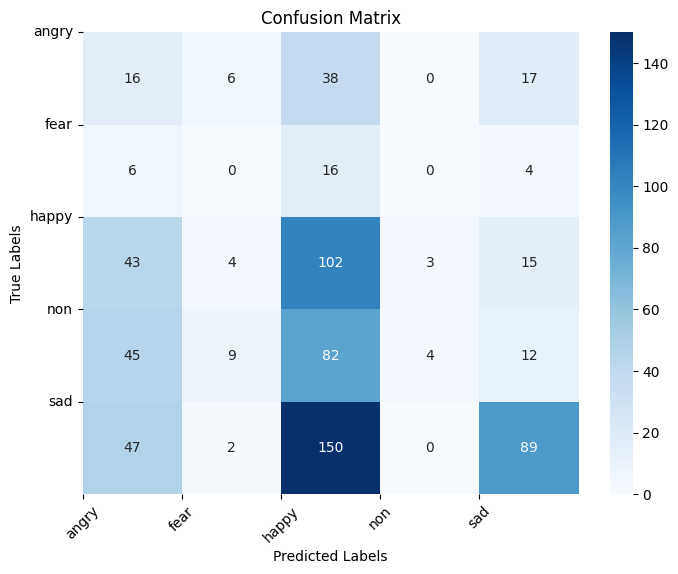

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.10      0.21      0.14        77
        fear       0.00      0.00      0.00        26
       happy       0.26      0.61      0.37       167
         non       0.57      0.03      0.05       152
         sad       0.65      0.31      0.42       288

    accuracy                           0.30       710
   macro avg       0.32      0.23      0.19       710
weighted avg       0.46      0.30      0.28       710



#### Length

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         186880      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 33s 214ms/step - loss: 1.4178 - accuracy: 0.3980
Epoch 2/50
89/89 [==============================] - 18s 203ms/step - loss: 1.3759 - accuracy: 0.3983
Epoch 3/50
89/89 [==============================] - 15s 167ms/step - loss: 1.2976 - accuracy: 0.4403
Epoch 4/50
89/89 [==============================] - 14s 161ms/step - loss: 1.1227 - accuracy: 0.5622
Epoch 5/50
89/89 [==============================] - 13s 148ms/step - loss: 0.7672 - accuracy: 0.7145
Epoch 6/50
89/89 [==============================] - 12s 135ms/step - loss: 0.5357 - accuracy: 0.8044
Epoch 7/50
89/89 [==============================] - 13s 149ms/step - loss: 0.3865 - accuracy: 0.8438
Epoch 8/50
89/89 [==============================] - 10s 106ms/step - loss: 0.3060 - accuracy: 0.8816
Epoch 9/50
89/89 [==============================] - 10s 115ms/step - loss: 0.8074 - accuracy: 0.8174
Epoch 10/50
89/89 [==============================] - 11s 127ms/step - loss: 0.2225 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 29.15%
Loss: 8.5419


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 25ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

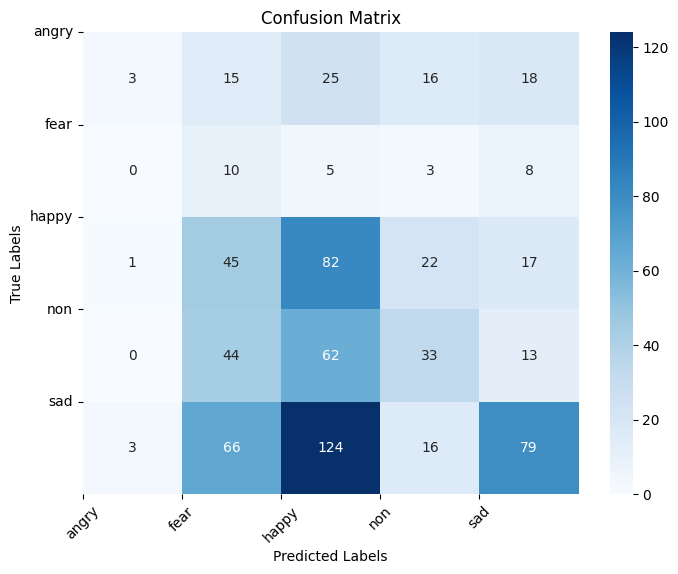

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.43      0.04      0.07        77
        fear       0.06      0.38      0.10        26
       happy       0.28      0.49      0.35       167
         non       0.37      0.22      0.27       152
         sad       0.59      0.27      0.37       288

    accuracy                           0.29       710
   macro avg       0.34      0.28      0.23       710
weighted avg       0.43      0.29      0.30       710



#### Hyper

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          186880      ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 40s 288ms/step - loss: 1.4147 - accuracy: 0.3955
Epoch 2/50
89/89 [==============================] - 22s 248ms/step - loss: 1.3808 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 19s 214ms/step - loss: 1.3366 - accuracy: 0.4128
Epoch 4/50
89/89 [==============================] - 17s 187ms/step - loss: 1.1299 - accuracy: 0.5241
Epoch 5/50
89/89 [==============================] - 15s 171ms/step - loss: 0.7578 - accuracy: 0.6919
Epoch 6/50
89/89 [==============================] - 15s 167ms/step - loss: 0.4595 - accuracy: 0.8340
Epoch 7/50
89/89 [==============================] - 12s 138ms/step - loss: 0.2247 - accuracy: 0.9136
Epoch 8/50
89/89 [==============================] - 15s 171ms/step - loss: 0.1376 - accuracy: 0.9507
Epoch 9/50
89/89 [==============================] - 13s 152ms/step - loss: 0.1070 - accuracy: 0.9651
Epoch 10/50
89/89 [==============================] - 11s 130ms/step - loss: 0.0801 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 37.32%
Loss: 6.6253


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

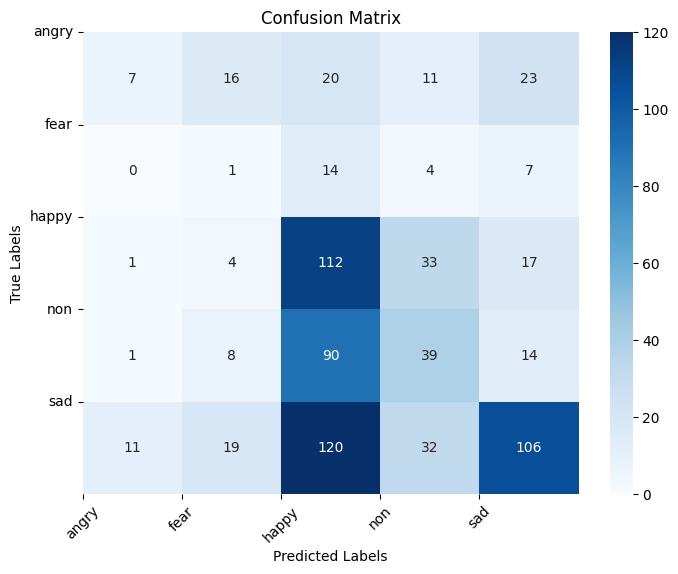

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.35      0.09      0.14        77
        fear       0.02      0.04      0.03        26
       happy       0.31      0.67      0.43       167
         non       0.33      0.26      0.29       152
         sad       0.63      0.37      0.47       288

    accuracy                           0.37       710
   macro avg       0.33      0.28      0.27       710
weighted avg       0.44      0.37      0.37       710



#### Escape

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128)         186880      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 31s 234ms/step - loss: 1.4242 - accuracy: 0.3976
Epoch 2/50
89/89 [==============================] - 17s 195ms/step - loss: 1.3839 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 18s 200ms/step - loss: 1.3373 - accuracy: 0.4008
Epoch 4/50
89/89 [==============================] - 14s 154ms/step - loss: 1.1250 - accuracy: 0.5153
Epoch 5/50
89/89 [==============================] - 14s 149ms/step - loss: 0.8380 - accuracy: 0.6429
Epoch 6/50
89/89 [==============================] - 13s 141ms/step - loss: 0.6066 - accuracy: 0.7610
Epoch 7/50
89/89 [==============================] - 12s 129ms/step - loss: 0.8095 - accuracy: 0.7529
Epoch 8/50
89/89 [==============================] - 12s 131ms/step - loss: 0.2746 - accuracy: 0.9006
Epoch 9/50
89/89 [==============================] - 9s 100ms/step - loss: 0.1715 - accuracy: 0.9404
Epoch 10/50
89/89 [==============================] - 9s 106ms/step - loss: 0.1199 - accuracy

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 31.41%
Loss: 11.2471


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 24ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

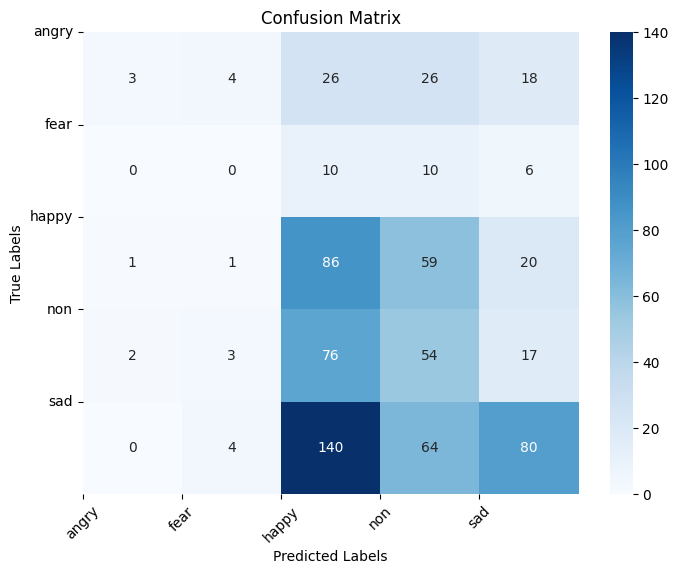

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.50      0.04      0.07        77
        fear       0.00      0.00      0.00        26
       happy       0.25      0.51      0.34       167
         non       0.25      0.36      0.30       152
         sad       0.57      0.28      0.37       288

    accuracy                           0.31       710
   macro avg       0.32      0.24      0.22       710
weighted avg       0.40      0.31      0.30       710



#### Entropy

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 128)         186880      ['embedding_6[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 30s 226ms/step - loss: 1.4196 - accuracy: 0.3835
Epoch 2/50
89/89 [==============================] - 19s 210ms/step - loss: 1.3880 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 183ms/step - loss: 1.3417 - accuracy: 0.4304
Epoch 4/50
89/89 [==============================] - 13s 150ms/step - loss: 1.0841 - accuracy: 0.5583
Epoch 5/50
89/89 [==============================] - 13s 146ms/step - loss: 0.7489 - accuracy: 0.7180
Epoch 6/50
89/89 [==============================] - 11s 127ms/step - loss: 0.5115 - accuracy: 0.8118
Epoch 7/50
89/89 [==============================] - 11s 127ms/step - loss: 0.3778 - accuracy: 0.8428
Epoch 8/50
89/89 [==============================] - 10s 117ms/step - loss: 0.2922 - accuracy: 0.8826
Epoch 9/50
89/89 [==============================] - 9s 106ms/step - loss: 0.2253 - accuracy: 0.9214
Epoch 10/50
89/89 [==============================] - 11s 118ms/step - loss: 0.1602 - accurac

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 29.58%
Loss: 5.7250


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 3s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

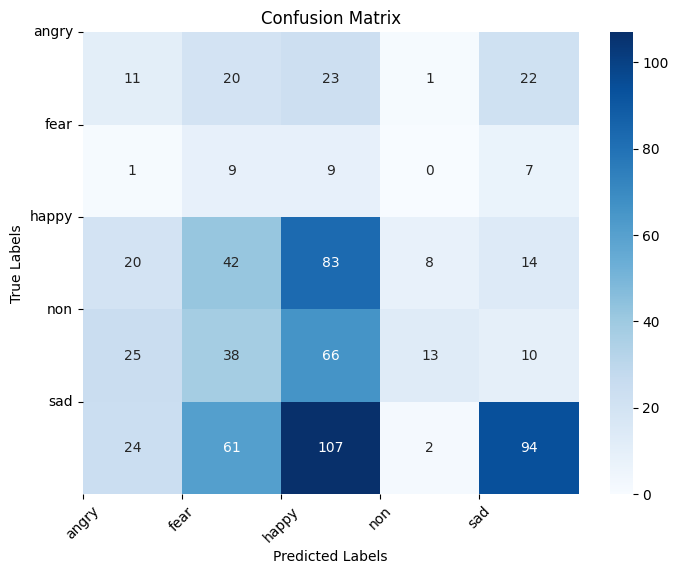

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.14      0.14      0.14        77
        fear       0.05      0.35      0.09        26
       happy       0.29      0.50      0.36       167
         non       0.54      0.09      0.15       152
         sad       0.64      0.33      0.43       288

    accuracy                           0.30       710
   macro avg       0.33      0.28      0.24       710
weighted avg       0.46      0.30      0.31       710



#### First_single

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 128)         186880      ['embedding_7[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 222ms/step - loss: 1.4184 - accuracy: 0.3969
Epoch 2/50
89/89 [==============================] - 19s 209ms/step - loss: 1.3872 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 175ms/step - loss: 1.3357 - accuracy: 0.4099
Epoch 4/50
89/89 [==============================] - 13s 144ms/step - loss: 1.1787 - accuracy: 0.5263
Epoch 5/50
89/89 [==============================] - 14s 152ms/step - loss: 1.0433 - accuracy: 0.5788
Epoch 6/50
89/89 [==============================] - 12s 140ms/step - loss: 0.6513 - accuracy: 0.7473
Epoch 7/50
89/89 [==============================] - 11s 122ms/step - loss: 0.4625 - accuracy: 0.8206
Epoch 8/50
89/89 [==============================] - 10s 115ms/step - loss: 0.3251 - accuracy: 0.8844
Epoch 9/50
89/89 [==============================] - 11s 122ms/step - loss: 0.2293 - accuracy: 0.9295
Epoch 10/50
89/89 [==============================] - 10s 107ms/step - loss: 0.1882 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 34.08%
Loss: 9.9257


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 25ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

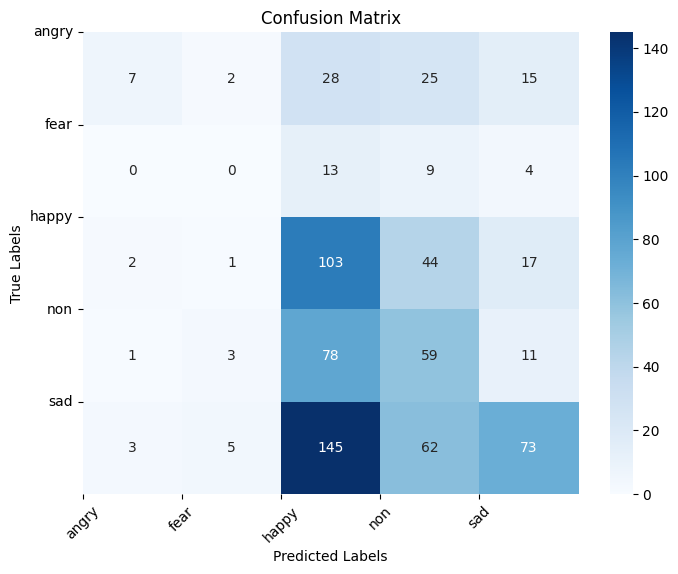

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.54      0.09      0.16        77
        fear       0.00      0.00      0.00        26
       happy       0.28      0.62      0.39       167
         non       0.30      0.39      0.34       152
         sad       0.61      0.25      0.36       288

    accuracy                           0.34       710
   macro avg       0.34      0.27      0.25       710
weighted avg       0.43      0.34      0.32       710



#### First_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 128)         186880      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 32s 241ms/step - loss: 1.4203 - accuracy: 0.3980
Epoch 2/50
89/89 [==============================] - 26s 292ms/step - loss: 1.3767 - accuracy: 0.4008
Epoch 3/50
89/89 [==============================] - 23s 264ms/step - loss: 1.2744 - accuracy: 0.4582
Epoch 4/50
89/89 [==============================] - 18s 200ms/step - loss: 0.9680 - accuracy: 0.6137
Epoch 5/50
89/89 [==============================] - 13s 149ms/step - loss: 0.6520 - accuracy: 0.7473
Epoch 6/50
89/89 [==============================] - 12s 136ms/step - loss: 0.4289 - accuracy: 0.8266
Epoch 7/50
89/89 [==============================] - 11s 125ms/step - loss: 0.3001 - accuracy: 0.8805
Epoch 8/50
89/89 [==============================] - 9s 106ms/step - loss: 0.1734 - accuracy: 0.9415
Epoch 9/50
89/89 [==============================] - 10s 116ms/step - loss: 0.1060 - accuracy: 0.9676
Epoch 10/50
89/89 [==============================] - 10s 115ms/step - loss: 0.0367 - accurac

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 40.99%
Loss: 7.8128


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 3s 31ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

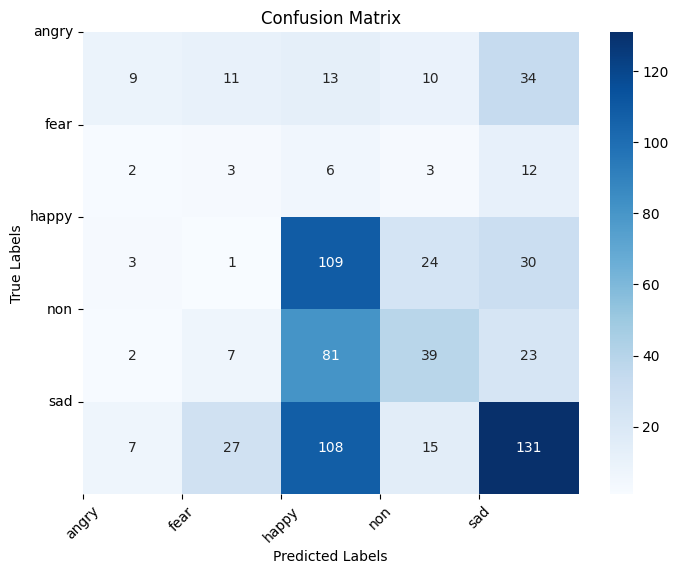

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.39      0.12      0.18        77
        fear       0.06      0.12      0.08        26
       happy       0.34      0.65      0.45       167
         non       0.43      0.26      0.32       152
         sad       0.57      0.45      0.51       288

    accuracy                           0.41       710
   macro avg       0.36      0.32      0.31       710
weighted avg       0.45      0.41      0.40       710



#### Second_single

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 128)         186880      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 27s 225ms/step - loss: 1.4181 - accuracy: 0.3969
Epoch 2/50
89/89 [==============================] - 17s 188ms/step - loss: 1.3827 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 15s 171ms/step - loss: 1.3332 - accuracy: 0.4099
Epoch 4/50
89/89 [==============================] - 14s 153ms/step - loss: 1.1600 - accuracy: 0.5058
Epoch 5/50
89/89 [==============================] - 12s 140ms/step - loss: 0.7987 - accuracy: 0.6419
Epoch 6/50
89/89 [==============================] - 12s 139ms/step - loss: 0.5201 - accuracy: 0.7441
Epoch 7/50
89/89 [==============================] - 11s 121ms/step - loss: 0.3835 - accuracy: 0.8421
Epoch 8/50
89/89 [==============================] - 10s 112ms/step - loss: 0.2716 - accuracy: 0.9045
Epoch 9/50
89/89 [==============================] - 10s 109ms/step - loss: 0.1694 - accuracy: 0.9418
Epoch 10/50
89/89 [==============================] - 10s 116ms/step - loss: 0.1076 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 33.38%
Loss: 7.3992


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

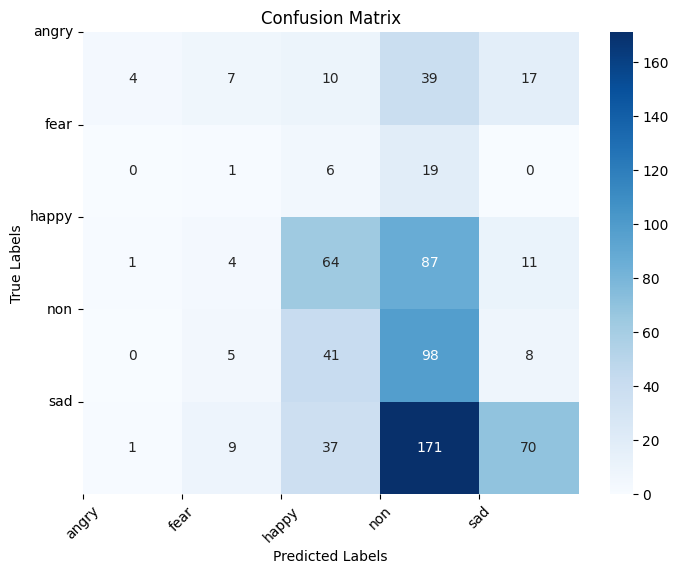

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.67      0.05      0.10        77
        fear       0.04      0.04      0.04        26
       happy       0.41      0.38      0.39       167
         non       0.24      0.64      0.35       152
         sad       0.66      0.24      0.36       288

    accuracy                           0.33       710
   macro avg       0.40      0.27      0.25       710
weighted avg       0.49      0.33      0.32       710



#### Second_single_god

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 128)         186880      ['embedding_5[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 35s 246ms/step - loss: 1.4114 - accuracy: 0.3941
Epoch 2/50
89/89 [==============================] - 17s 192ms/step - loss: 1.3844 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 179ms/step - loss: 1.3394 - accuracy: 0.4061
Epoch 4/50
89/89 [==============================] - 18s 200ms/step - loss: 1.1672 - accuracy: 0.5048
Epoch 5/50
89/89 [==============================] - 14s 160ms/step - loss: 0.9012 - accuracy: 0.6087
Epoch 6/50
89/89 [==============================] - 13s 146ms/step - loss: 0.6671 - accuracy: 0.7212
Epoch 7/50
89/89 [==============================] - 11s 126ms/step - loss: 0.4133 - accuracy: 0.8569
Epoch 8/50
89/89 [==============================] - 12s 133ms/step - loss: 0.2283 - accuracy: 0.9246
Epoch 9/50
89/89 [==============================] - 10s 118ms/step - loss: 0.1333 - accuracy: 0.9545
Epoch 10/50
89/89 [==============================] - 9s 104ms/step - loss: 0.1029 - accurac

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 34.23%
Loss: 10.3491


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

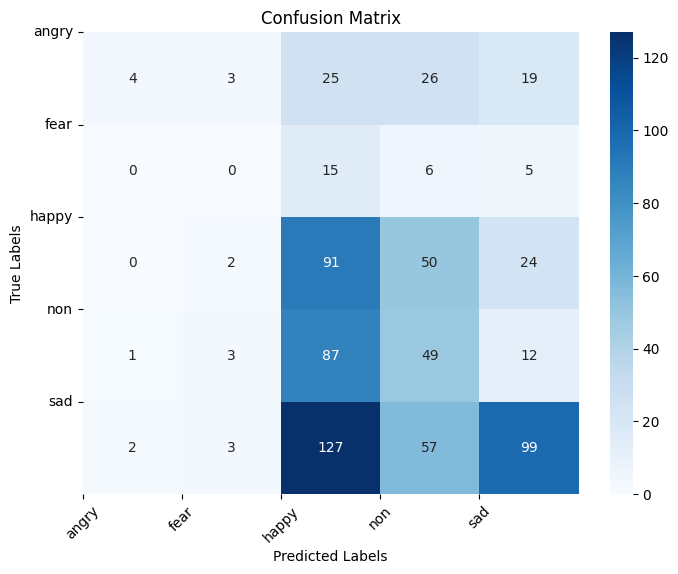

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.57      0.05      0.10        77
        fear       0.00      0.00      0.00        26
       happy       0.26      0.54      0.36       167
         non       0.26      0.32      0.29       152
         sad       0.62      0.34      0.44       288

    accuracy                           0.34       710
   macro avg       0.34      0.25      0.24       710
weighted avg       0.43      0.34      0.34       710



#### Second_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 128)         186880      ['embedding_6[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 34s 249ms/step - loss: 1.4221 - accuracy: 0.3951
Epoch 2/50
89/89 [==============================] - 18s 201ms/step - loss: 1.3883 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 175ms/step - loss: 1.3582 - accuracy: 0.4001
Epoch 4/50
89/89 [==============================] - 16s 179ms/step - loss: 1.2153 - accuracy: 0.4670
Epoch 5/50
89/89 [==============================] - 14s 158ms/step - loss: 0.8858 - accuracy: 0.6264
Epoch 6/50
89/89 [==============================] - 14s 154ms/step - loss: 0.5449 - accuracy: 0.7963
Epoch 7/50
89/89 [==============================] - 10s 116ms/step - loss: 0.3539 - accuracy: 0.8696
Epoch 8/50
89/89 [==============================] - 10s 115ms/step - loss: 0.2282 - accuracy: 0.9239
Epoch 9/50
89/89 [==============================] - 11s 118ms/step - loss: 0.3078 - accuracy: 0.9397
Epoch 10/50
89/89 [==============================] - 10s 108ms/step - loss: 0.2146 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 32.68%
Loss: 8.8078


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 36ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

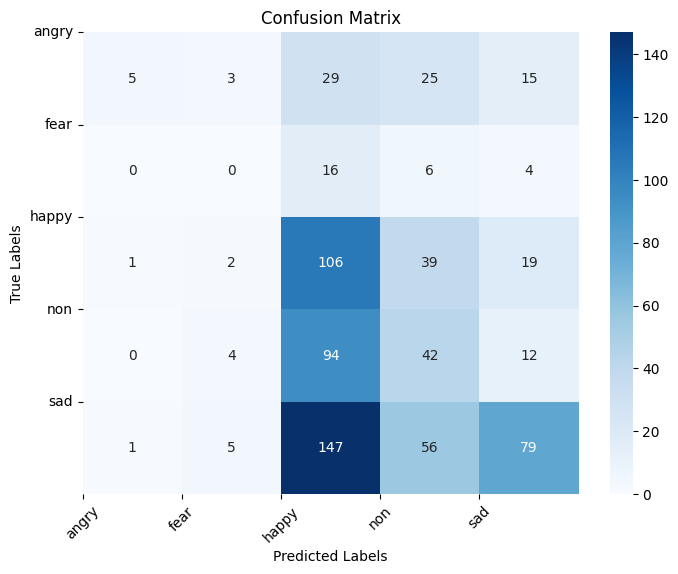

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.71      0.06      0.12        77
        fear       0.00      0.00      0.00        26
       happy       0.27      0.63      0.38       167
         non       0.25      0.28      0.26       152
         sad       0.61      0.27      0.38       288

    accuracy                           0.33       710
   macro avg       0.37      0.25      0.23       710
weighted avg       0.44      0.33      0.31       710



#### Third_single

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          186880      ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 42s 303ms/step - loss: 1.4188 - accuracy: 0.3944
Epoch 2/50
89/89 [==============================] - 24s 262ms/step - loss: 1.3861 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 21s 231ms/step - loss: 1.3230 - accuracy: 0.4300
Epoch 4/50
89/89 [==============================] - 19s 211ms/step - loss: 0.9772 - accuracy: 0.5753
Epoch 5/50
89/89 [==============================] - 17s 196ms/step - loss: 0.5789 - accuracy: 0.7437
Epoch 6/50
89/89 [==============================] - 15s 171ms/step - loss: 0.3021 - accuracy: 0.8893
Epoch 7/50
89/89 [==============================] - 15s 165ms/step - loss: 0.1283 - accuracy: 0.9538
Epoch 8/50
89/89 [==============================] - 14s 157ms/step - loss: 0.0763 - accuracy: 0.9729
Epoch 9/50
89/89 [==============================] - 12s 139ms/step - loss: 0.0440 - accuracy: 0.9873
Epoch 10/50
89/89 [==============================] - 11s 128ms/step - loss: 0.0289 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 44.65%
Loss: 5.3833


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

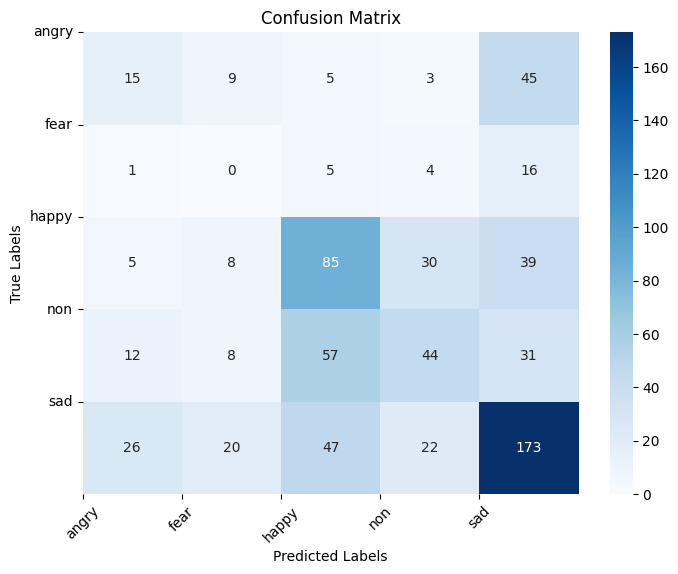

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.25      0.19      0.22        77
        fear       0.00      0.00      0.00        26
       happy       0.43      0.51      0.46       167
         non       0.43      0.29      0.35       152
         sad       0.57      0.60      0.58       288

    accuracy                           0.45       710
   macro avg       0.34      0.32      0.32       710
weighted avg       0.45      0.45      0.44       710



#### Third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128)         186880      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 36s 264ms/step - loss: 1.4216 - accuracy: 0.3937
Epoch 2/50
89/89 [==============================] - 17s 195ms/step - loss: 1.3858 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 184ms/step - loss: 1.3380 - accuracy: 0.4138
Epoch 4/50
89/89 [==============================] - 15s 168ms/step - loss: 1.1020 - accuracy: 0.5435
Epoch 5/50
89/89 [==============================] - 15s 165ms/step - loss: 0.7174 - accuracy: 0.7166
Epoch 6/50
89/89 [==============================] - 13s 141ms/step - loss: 0.3822 - accuracy: 0.8523
Epoch 7/50
89/89 [==============================] - 12s 134ms/step - loss: 0.2071 - accuracy: 0.9263
Epoch 8/50
89/89 [==============================] - 12s 132ms/step - loss: 0.1162 - accuracy: 0.9595
Epoch 9/50
89/89 [==============================] - 10s 111ms/step - loss: 0.0784 - accuracy: 0.9757
Epoch 10/50
89/89 [==============================] - 10s 107ms/step - loss: 0.0386 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 39.01%
Loss: 7.4268


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

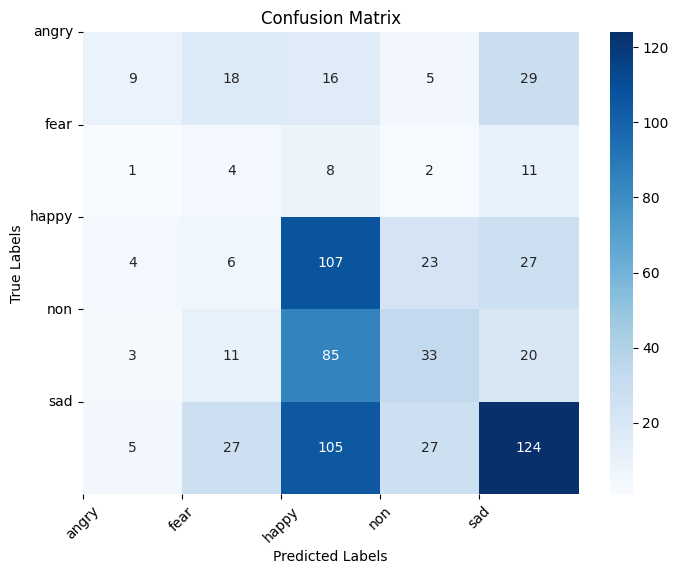

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.41      0.12      0.18        77
        fear       0.06      0.15      0.09        26
       happy       0.33      0.64      0.44       167
         non       0.37      0.22      0.27       152
         sad       0.59      0.43      0.50       288

    accuracy                           0.39       710
   macro avg       0.35      0.31      0.30       710
weighted avg       0.44      0.39      0.39       710



#### Code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(1,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         186880      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 40s 284ms/step - loss: 1.4240 - accuracy: 0.3948
Epoch 2/50
89/89 [==============================] - 17s 193ms/step - loss: 1.3800 - accuracy: 0.3983
Epoch 3/50
89/89 [==============================] - 17s 195ms/step - loss: 1.3142 - accuracy: 0.4297
Epoch 4/50
89/89 [==============================] - 15s 167ms/step - loss: 0.9826 - accuracy: 0.5996
Epoch 5/50
89/89 [==============================] - 12s 132ms/step - loss: 0.5501 - accuracy: 0.7917
Epoch 6/50
89/89 [==============================] - 13s 138ms/step - loss: 0.2787 - accuracy: 0.8978
Epoch 7/50
89/89 [==============================] - 12s 133ms/step - loss: 0.1447 - accuracy: 0.9464
Epoch 8/50
89/89 [==============================] - 11s 124ms/step - loss: 0.1039 - accuracy: 0.9623
Epoch 9/50
89/89 [==============================] - 11s 127ms/step - loss: 0.0596 - accuracy: 0.9831
Epoch 10/50
89/89 [==============================] - 10s 107ms/step - loss: 0.0376 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 40.70%
Loss: 7.6009


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 24ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

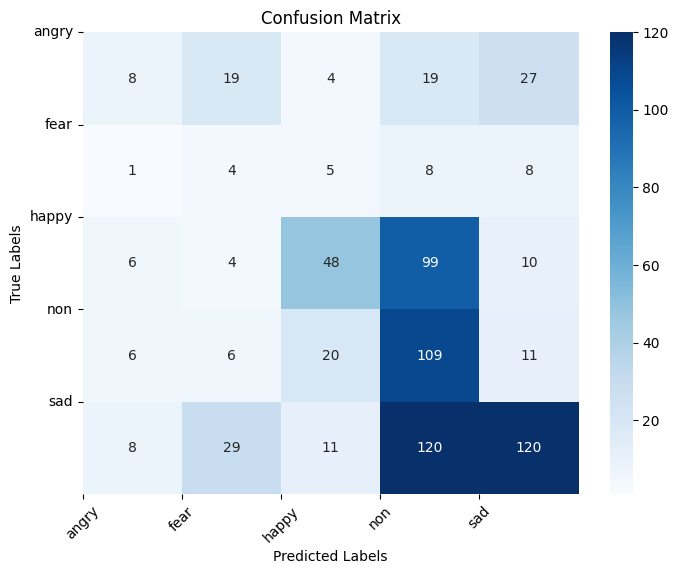

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.28      0.10      0.15        77
        fear       0.06      0.15      0.09        26
       happy       0.55      0.29      0.38       167
         non       0.31      0.72      0.43       152
         sad       0.68      0.42      0.52       288

    accuracy                           0.41       710
   macro avg       0.37      0.34      0.31       710
weighted avg       0.50      0.41      0.41       710



#### Positive+first_single+third_single+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(4,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 128)         186880      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 4)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 38s 290ms/step - loss: 1.4228 - accuracy: 0.3821
Epoch 2/50
89/89 [==============================] - 18s 206ms/step - loss: 1.3820 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 17s 190ms/step - loss: 1.3561 - accuracy: 0.4015
Epoch 4/50
89/89 [==============================] - 16s 179ms/step - loss: 1.1711 - accuracy: 0.4959
Epoch 5/50
89/89 [==============================] - 13s 148ms/step - loss: 0.8328 - accuracy: 0.6348
Epoch 6/50
89/89 [==============================] - 13s 147ms/step - loss: 0.5634 - accuracy: 0.7325
Epoch 7/50
89/89 [==============================] - 13s 144ms/step - loss: 0.3928 - accuracy: 0.8484
Epoch 8/50
89/89 [==============================] - 10s 108ms/step - loss: 0.2023 - accuracy: 0.9263
Epoch 9/50
89/89 [==============================] - 11s 121ms/step - loss: 0.0737 - accuracy: 0.9771
Epoch 10/50
89/89 [==============================] - 11s 121ms/step - loss: 0.0531 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 42.54%
Loss: 4.0512


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

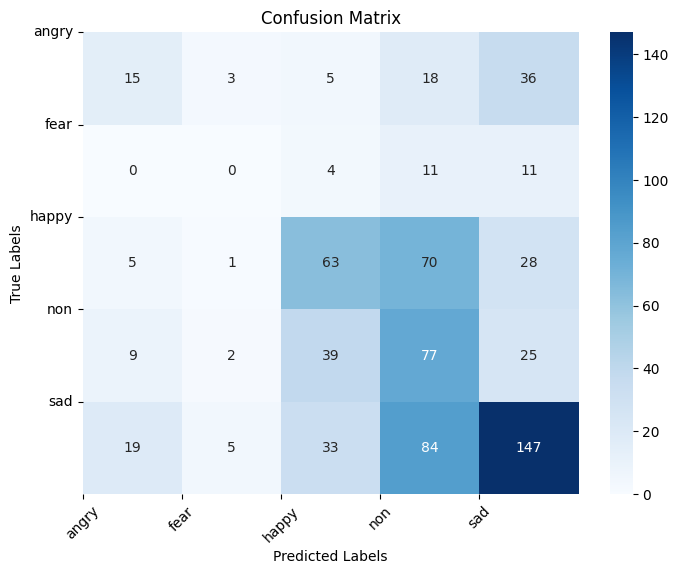

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.31      0.19      0.24        77
        fear       0.00      0.00      0.00        26
       happy       0.44      0.38      0.41       167
         non       0.30      0.51      0.37       152
         sad       0.60      0.51      0.55       288

    accuracy                           0.43       710
   macro avg       0.33      0.32      0.31       710
weighted avg       0.44      0.43      0.42       710



#### Negative+second_single+third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(3,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         186880      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 3)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 235ms/step - loss: 1.4267 - accuracy: 0.3941
Epoch 2/50
89/89 [==============================] - 18s 201ms/step - loss: 1.3864 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 18s 200ms/step - loss: 1.3073 - accuracy: 0.4314
Epoch 4/50
89/89 [==============================] - 14s 157ms/step - loss: 0.9505 - accuracy: 0.6066
Epoch 5/50
89/89 [==============================] - 13s 150ms/step - loss: 0.5863 - accuracy: 0.7674
Epoch 6/50
89/89 [==============================] - 13s 150ms/step - loss: 0.3307 - accuracy: 0.8886
Epoch 7/50
89/89 [==============================] - 11s 124ms/step - loss: 0.1585 - accuracy: 0.9499
Epoch 8/50
89/89 [==============================] - 12s 130ms/step - loss: 0.0930 - accuracy: 0.9669
Epoch 9/50
89/89 [==============================] - 9s 99ms/step - loss: 0.0784 - accuracy: 0.9725
Epoch 10/50
89/89 [==============================] - 10s 111ms/step - loss: 0.0646 - accuracy

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 43.24%
Loss: 6.4013


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

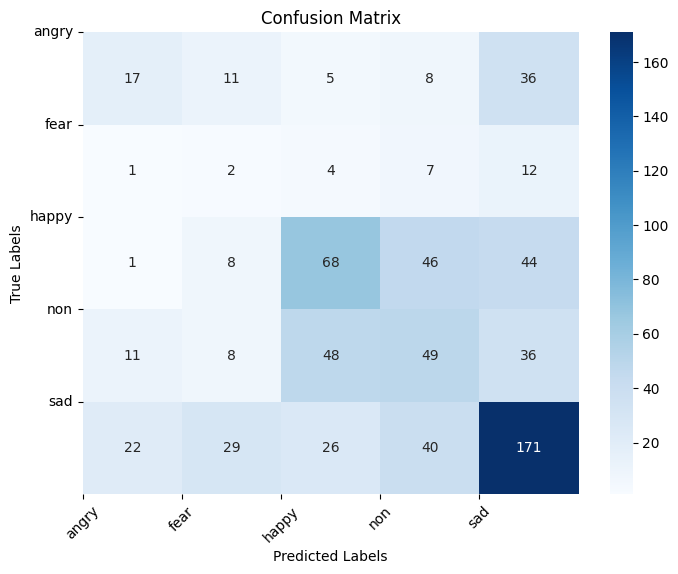

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.33      0.22      0.26        77
        fear       0.03      0.08      0.05        26
       happy       0.45      0.41      0.43       167
         non       0.33      0.32      0.32       152
         sad       0.57      0.59      0.58       288

    accuracy                           0.43       710
   macro avg       0.34      0.32      0.33       710
weighted avg       0.44      0.43      0.44       710



In [ ]:
# Get the weights of the last layer
weights = model.layers[-1].get_weights()[0]

# Calculate feature importance
feature_importance = np.abs(weights[:-5]).sum(axis=0) / np.abs(weights[:-5]).sum()

feature_importance

array([0.20792341, 0.19103405, 0.20331213, 0.1882222 , 0.20950827],
      dtype=float32)

#### Negation+second_single+third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(3,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          186880      ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 3)]          0           []                               
                                                                                              

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 40s 299ms/step - loss: 1.4219 - accuracy: 0.3937
Epoch 2/50
89/89 [==============================] - 21s 232ms/step - loss: 1.3834 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 21s 239ms/step - loss: 1.2989 - accuracy: 0.4413
Epoch 4/50
89/89 [==============================] - 16s 183ms/step - loss: 1.0138 - accuracy: 0.5876
Epoch 5/50
89/89 [==============================] - 16s 180ms/step - loss: 0.7501 - accuracy: 0.7145
Epoch 6/50
89/89 [==============================] - 14s 162ms/step - loss: 0.6870 - accuracy: 0.7793
Epoch 7/50
89/89 [==============================] - 14s 155ms/step - loss: 1.0140 - accuracy: 0.6398
Epoch 8/50
89/89 [==============================] - 11s 124ms/step - loss: 0.6747 - accuracy: 0.7494
Epoch 9/50
89/89 [==============================] - 13s 145ms/step - loss: 0.4101 - accuracy: 0.8421
Epoch 10/50
89/89 [==============================] - 12s 130ms/step - loss: 0.3077 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 31.83%
Loss: 6.8438


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 24ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

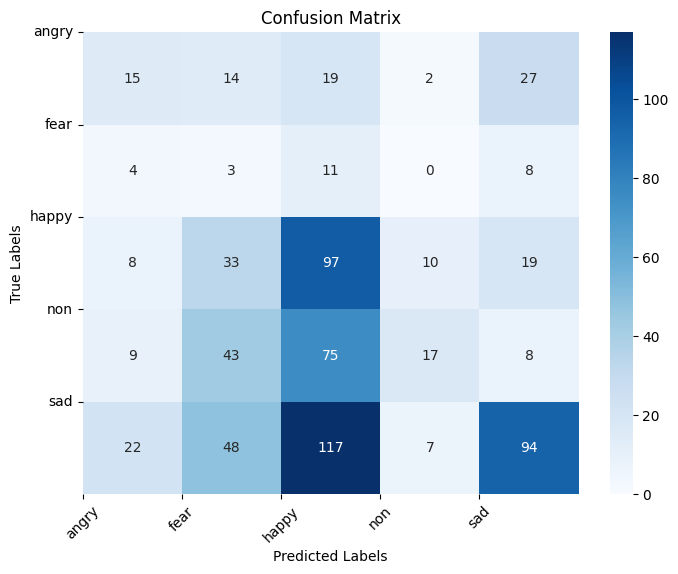

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.26      0.19      0.22        77
        fear       0.02      0.12      0.04        26
       happy       0.30      0.58      0.40       167
         non       0.47      0.11      0.18       152
         sad       0.60      0.33      0.42       288

    accuracy                           0.32       710
   macro avg       0.33      0.27      0.25       710
weighted avg       0.45      0.32      0.33       710



#### Negative+second_single+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(3,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          186880      ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 3)]          0           []                               
                                                                                              

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 39s 284ms/step - loss: 1.4256 - accuracy: 0.3870
Epoch 2/50
89/89 [==============================] - 22s 243ms/step - loss: 1.3901 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 20s 230ms/step - loss: 1.3702 - accuracy: 0.3976
Epoch 4/50
89/89 [==============================] - 17s 189ms/step - loss: 1.1547 - accuracy: 0.5199
Epoch 5/50
89/89 [==============================] - 16s 177ms/step - loss: 0.7516 - accuracy: 0.6732
Epoch 6/50
89/89 [==============================] - 14s 158ms/step - loss: 0.4651 - accuracy: 0.8079
Epoch 7/50
89/89 [==============================] - 15s 164ms/step - loss: 0.2824 - accuracy: 0.8981
Epoch 8/50
89/89 [==============================] - 14s 161ms/step - loss: 0.1365 - accuracy: 0.9535
Epoch 9/50
89/89 [==============================] - 11s 120ms/step - loss: 0.1059 - accuracy: 0.9658
Epoch 10/50
89/89 [==============================] - 11s 128ms/step - loss: 0.0708 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 37.75%
Loss: 7.1330


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 29ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

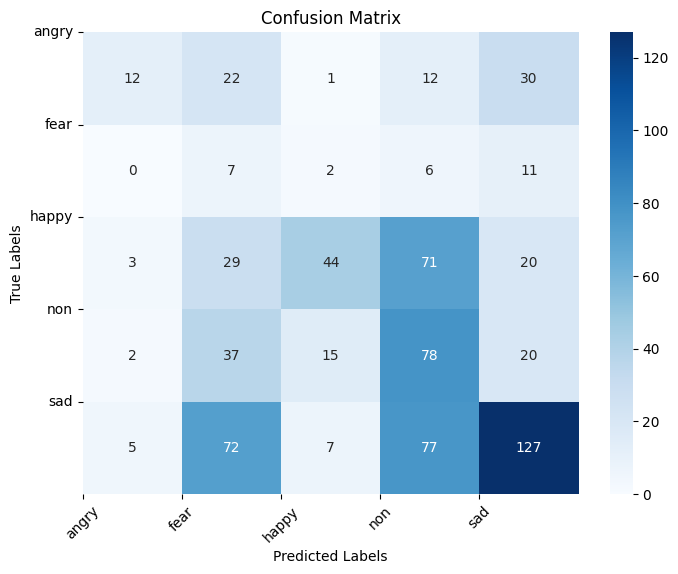

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.55      0.16      0.24        77
        fear       0.04      0.27      0.07        26
       happy       0.64      0.26      0.37       167
         non       0.32      0.51      0.39       152
         sad       0.61      0.44      0.51       288

    accuracy                           0.38       710
   macro avg       0.43      0.33      0.32       710
weighted avg       0.53      0.38      0.41       710



#### Positive+second_single+third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(3,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128)         186880      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 3)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 216ms/step - loss: 1.4150 - accuracy: 0.3934
Epoch 2/50
89/89 [==============================] - 17s 193ms/step - loss: 1.3821 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 17s 186ms/step - loss: 1.3305 - accuracy: 0.4110
Epoch 4/50
89/89 [==============================] - 15s 166ms/step - loss: 1.1424 - accuracy: 0.5241
Epoch 5/50
89/89 [==============================] - 13s 144ms/step - loss: 0.8622 - accuracy: 0.6500
Epoch 6/50
89/89 [==============================] - 10s 112ms/step - loss: 0.6428 - accuracy: 0.7578
Epoch 7/50
89/89 [==============================] - 12s 137ms/step - loss: 0.4583 - accuracy: 0.8174
Epoch 8/50
89/89 [==============================] - 12s 135ms/step - loss: 0.3390 - accuracy: 0.8590
Epoch 9/50
89/89 [==============================] - 10s 118ms/step - loss: 0.2637 - accuracy: 0.9034
Epoch 10/50
89/89 [==============================] - 8s 95ms/step - loss: 0.1696 - accuracy

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 29.58%
Loss: 10.2123


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 33ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

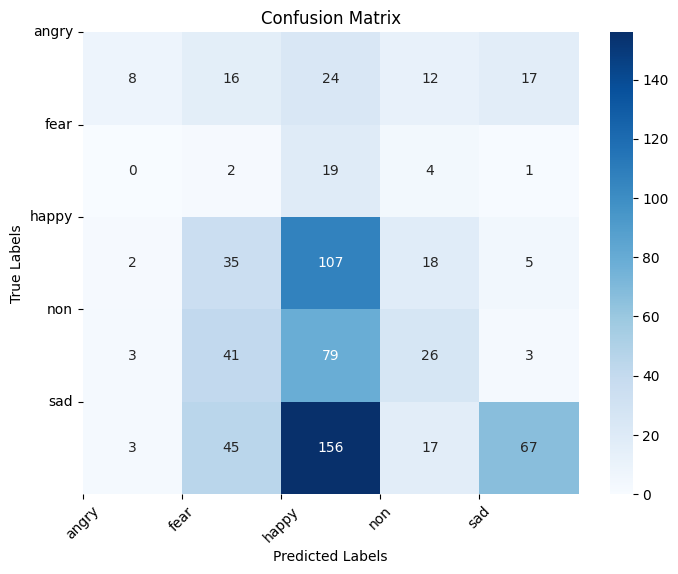

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.50      0.10      0.17        77
        fear       0.01      0.08      0.02        26
       happy       0.28      0.64      0.39       167
         non       0.34      0.17      0.23       152
         sad       0.72      0.23      0.35       288

    accuracy                           0.30       710
   macro avg       0.37      0.25      0.23       710
weighted avg       0.48      0.30      0.30       710



#### Negative+third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         186880      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 225ms/step - loss: 1.4313 - accuracy: 0.3817
Epoch 2/50
89/89 [==============================] - 17s 194ms/step - loss: 1.3807 - accuracy: 0.3983
Epoch 3/50
89/89 [==============================] - 18s 204ms/step - loss: 1.2868 - accuracy: 0.4607
Epoch 4/50
89/89 [==============================] - 16s 176ms/step - loss: 0.9617 - accuracy: 0.6020
Epoch 5/50
89/89 [==============================] - 13s 152ms/step - loss: 0.6525 - accuracy: 0.7353
Epoch 6/50
89/89 [==============================] - 12s 133ms/step - loss: 0.3981 - accuracy: 0.8590
Epoch 7/50
89/89 [==============================] - 12s 137ms/step - loss: 0.1850 - accuracy: 0.9394
Epoch 8/50
89/89 [==============================] - 10s 109ms/step - loss: 0.1069 - accuracy: 0.9616
Epoch 9/50
89/89 [==============================] - 10s 115ms/step - loss: 0.0727 - accuracy: 0.9764
Epoch 10/50
89/89 [==============================] - 11s 123ms/step - loss: 0.0684 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 42.25%
Loss: 7.0831


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 25ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

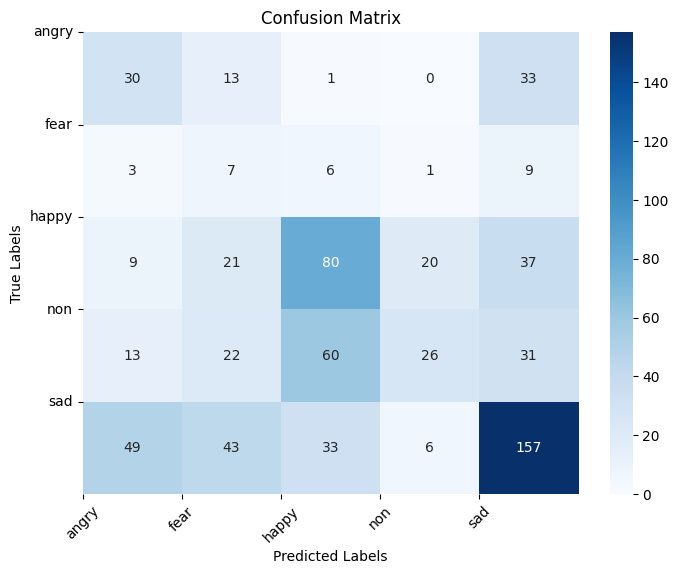

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.29      0.39      0.33        77
        fear       0.07      0.27      0.11        26
       happy       0.44      0.48      0.46       167
         non       0.49      0.17      0.25       152
         sad       0.59      0.55      0.57       288

    accuracy                           0.42       710
   macro avg       0.38      0.37      0.34       710
weighted avg       0.48      0.42      0.43       710



#### Negative+second_single

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 128)         186880      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 231ms/step - loss: 1.4346 - accuracy: 0.3913
Epoch 2/50
89/89 [==============================] - 17s 191ms/step - loss: 1.3567 - accuracy: 0.4096
Epoch 3/50
89/89 [==============================] - 16s 174ms/step - loss: 1.1975 - accuracy: 0.5083
Epoch 4/50
89/89 [==============================] - 15s 168ms/step - loss: 0.8663 - accuracy: 0.6073
Epoch 5/50
89/89 [==============================] - 14s 155ms/step - loss: 0.6208 - accuracy: 0.7124
Epoch 6/50
89/89 [==============================] - 13s 151ms/step - loss: 0.4425 - accuracy: 0.8142
Epoch 7/50
89/89 [==============================] - 12s 139ms/step - loss: 0.2000 - accuracy: 0.9288
Epoch 8/50
89/89 [==============================] - 11s 119ms/step - loss: 0.0927 - accuracy: 0.9746
Epoch 9/50
89/89 [==============================] - 10s 116ms/step - loss: 0.0513 - accuracy: 0.9848
Epoch 10/50
89/89 [==============================] - 12s 128ms/step - loss: 0.0225 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 43.38%
Loss: 5.7948


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

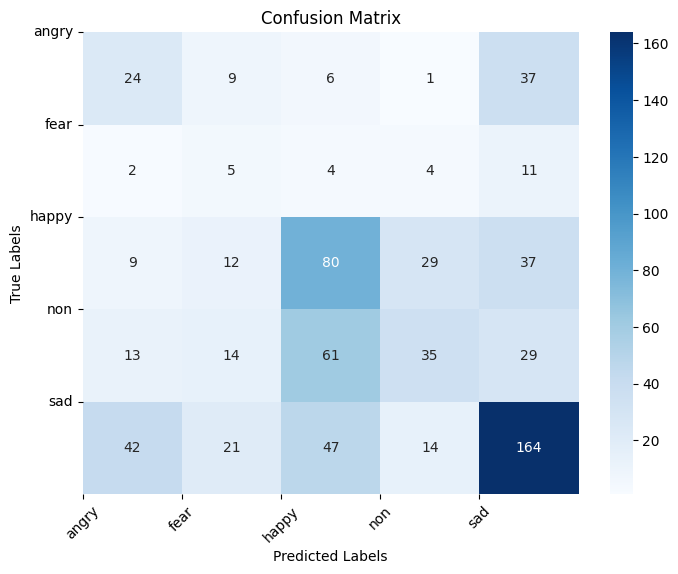

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.27      0.31      0.29        77
        fear       0.08      0.19      0.11        26
       happy       0.40      0.48      0.44       167
         non       0.42      0.23      0.30       152
         sad       0.59      0.57      0.58       288

    accuracy                           0.43       710
   macro avg       0.35      0.36      0.34       710
weighted avg       0.46      0.43      0.44       710



#### Positive+second_single

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 128)         186880      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 46s 413ms/step - loss: 1.4229 - accuracy: 0.3814
Epoch 2/50
89/89 [==============================] - 19s 209ms/step - loss: 1.3854 - accuracy: 0.3976
Epoch 3/50
89/89 [==============================] - 15s 171ms/step - loss: 1.3665 - accuracy: 0.4029
Epoch 4/50
89/89 [==============================] - 13s 150ms/step - loss: 1.1950 - accuracy: 0.5009
Epoch 5/50
89/89 [==============================] - 14s 153ms/step - loss: 0.8975 - accuracy: 0.6172
Epoch 6/50
89/89 [==============================] - 13s 145ms/step - loss: 0.6532 - accuracy: 0.7244
Epoch 7/50
89/89 [==============================] - 11s 127ms/step - loss: 0.4237 - accuracy: 0.8527
Epoch 8/50
89/89 [==============================] - 11s 118ms/step - loss: 0.2538 - accuracy: 0.9108
Epoch 9/50
89/89 [==============================] - 10s 115ms/step - loss: 0.1861 - accuracy: 0.9380
Epoch 10/50
89/89 [==============================] - 10s 115ms/step - loss: 0.1102 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 34.65%
Loss: 8.9069


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

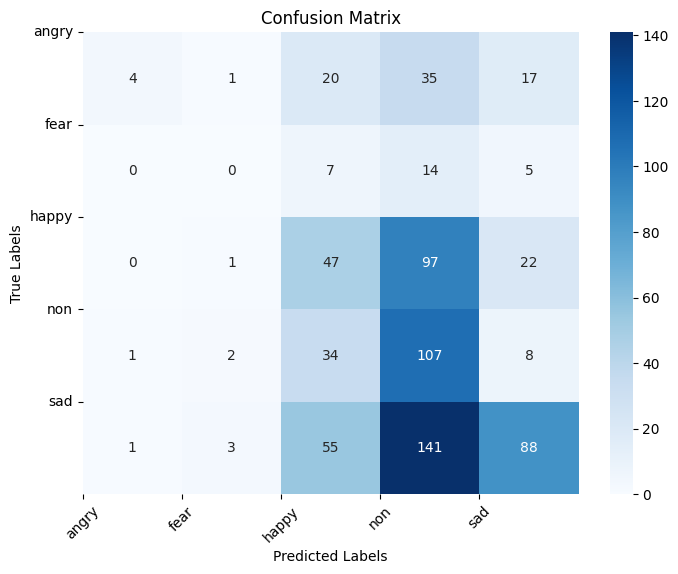

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.67      0.05      0.10        77
        fear       0.00      0.00      0.00        26
       happy       0.29      0.28      0.28       167
         non       0.27      0.70      0.39       152
         sad       0.63      0.31      0.41       288

    accuracy                           0.35       710
   macro avg       0.37      0.27      0.24       710
weighted avg       0.45      0.35      0.33       710



#### Second_single+third_plural

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 128)         186880      ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 220ms/step - loss: 1.4209 - accuracy: 0.3955
Epoch 2/50
89/89 [==============================] - 16s 181ms/step - loss: 1.3780 - accuracy: 0.3994
Epoch 3/50
89/89 [==============================] - 16s 174ms/step - loss: 1.3187 - accuracy: 0.4233
Epoch 4/50
89/89 [==============================] - 15s 165ms/step - loss: 1.0165 - accuracy: 0.5753
Epoch 5/50
89/89 [==============================] - 14s 163ms/step - loss: 0.6677 - accuracy: 0.7420
Epoch 6/50
89/89 [==============================] - 12s 132ms/step - loss: 0.4291 - accuracy: 0.8396
Epoch 7/50
89/89 [==============================] - 11s 127ms/step - loss: 0.2704 - accuracy: 0.9140
Epoch 8/50
89/89 [==============================] - 11s 124ms/step - loss: 0.1710 - accuracy: 0.9468
Epoch 9/50
89/89 [==============================] - 11s 123ms/step - loss: 0.1239 - accuracy: 0.9577
Epoch 10/50
89/89 [==============================] - 10s 109ms/step - loss: 0.0989 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 33.52%
Loss: 9.4881


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 26ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

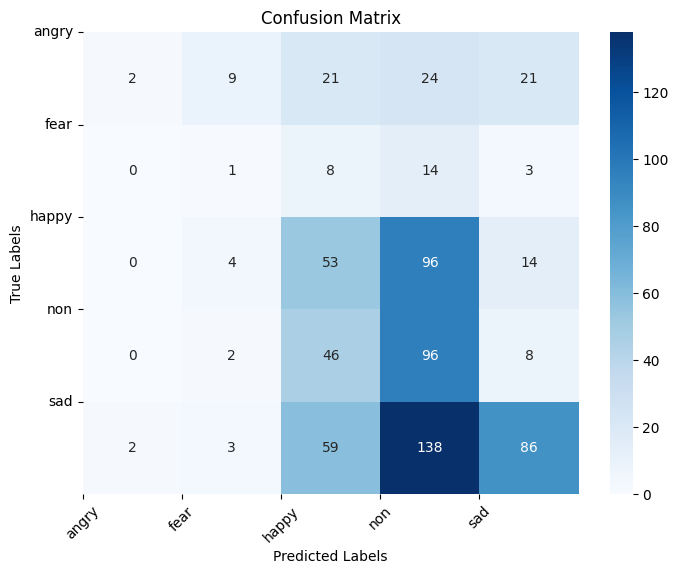

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.50      0.03      0.05        77
        fear       0.05      0.04      0.04        26
       happy       0.28      0.32      0.30       167
         non       0.26      0.63      0.37       152
         sad       0.65      0.30      0.41       288

    accuracy                           0.34       710
   macro avg       0.35      0.26      0.23       710
weighted avg       0.44      0.34      0.32       710



#### Negative+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 128)         186880      ['embedding_5[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 28s 220ms/step - loss: 1.4239 - accuracy: 0.3920
Epoch 2/50
89/89 [==============================] - 18s 197ms/step - loss: 1.3805 - accuracy: 0.3976
Epoch 3/50
89/89 [==============================] - 15s 173ms/step - loss: 1.2888 - accuracy: 0.4533
Epoch 4/50
89/89 [==============================] - 14s 154ms/step - loss: 0.9489 - accuracy: 0.6024
Epoch 5/50
89/89 [==============================] - 13s 152ms/step - loss: 0.5735 - accuracy: 0.7589
Epoch 6/50
89/89 [==============================] - 12s 132ms/step - loss: 0.3077 - accuracy: 0.8872
Epoch 7/50
89/89 [==============================] - 10s 115ms/step - loss: 0.1416 - accuracy: 0.9496
Epoch 8/50
89/89 [==============================] - 11s 126ms/step - loss: 0.0945 - accuracy: 0.9644
Epoch 9/50
89/89 [==============================] - 10s 106ms/step - loss: 0.0798 - accuracy: 0.9697
Epoch 10/50
89/89 [==============================] - 9s 106ms/step - loss: 0.0678 - accurac

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 42.39%
Loss: 7.0224


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 35ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

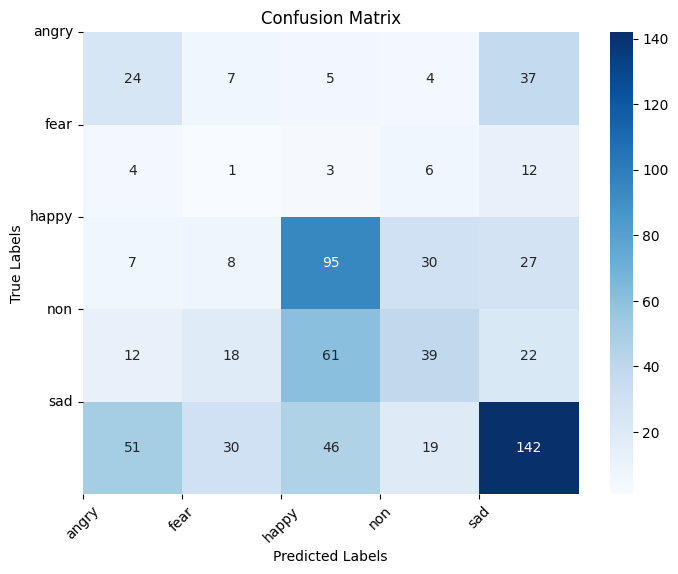

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.24      0.31      0.27        77
        fear       0.02      0.04      0.02        26
       happy       0.45      0.57      0.50       167
         non       0.40      0.26      0.31       152
         sad       0.59      0.49      0.54       288

    accuracy                           0.42       710
   macro avg       0.34      0.33      0.33       710
weighted avg       0.46      0.42      0.43       710



#### Positive+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(2,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model = Model(inputs=[text_inputs, feature_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 128)         186880      ['embedding_5[0][0]']            
 l)                                                                                               
                                                                                                  
 feature (InputLayer)           [(None, 2)]          0           []                         

In [ ]:
model.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 29s 239ms/step - loss: 1.4172 - accuracy: 0.3958
Epoch 2/50
89/89 [==============================] - 17s 192ms/step - loss: 1.3845 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 16s 179ms/step - loss: 1.2917 - accuracy: 0.4487
Epoch 4/50
89/89 [==============================] - 14s 160ms/step - loss: 0.9601 - accuracy: 0.6098
Epoch 5/50
89/89 [==============================] - 14s 161ms/step - loss: 0.5644 - accuracy: 0.8012
Epoch 6/50
89/89 [==============================] - 13s 149ms/step - loss: 0.2330 - accuracy: 0.9256
Epoch 7/50
89/89 [==============================] - 11s 122ms/step - loss: 0.1208 - accuracy: 0.9563
Epoch 8/50
89/89 [==============================] - 10s 112ms/step - loss: 0.0686 - accuracy: 0.9789
Epoch 9/50
89/89 [==============================] - 11s 129ms/step - loss: 0.0447 - accuracy: 0.9870
Epoch 10/50
89/89 [==============================] - 10s 112ms/step - loss: 0.0253 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 36.34%
Loss: 5.8113


In [ ]:
# Make predictions

predictionsF = model.predict([feature_test, adfeature_test])
predicted_labelsF = np.argmax(predictionsF, axis=1)

23/23 [==============================] - 2s 31ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

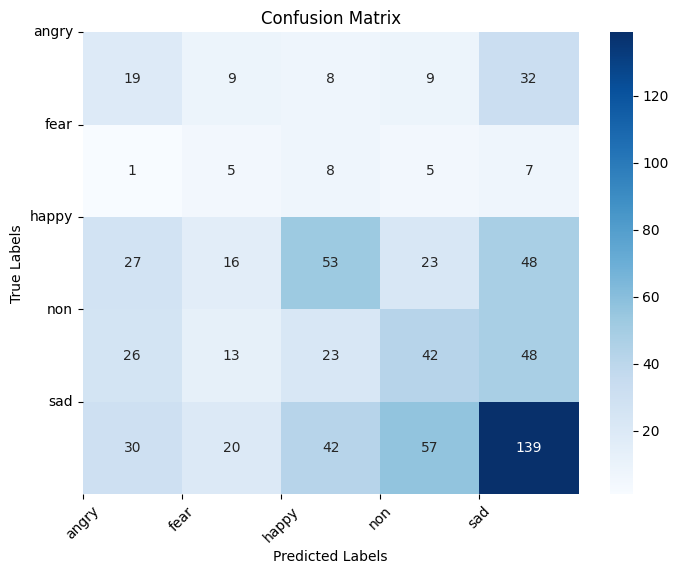

In [ ]:


# Calculate the confusion matrix
cmF = confusion_matrix(true_labels, predicted_labelsF)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF = classification_report(true_labels, predicted_labelsF, target_names = class_names)

# Print the classification report
print(reportF)


              precision    recall  f1-score   support

       angry       0.18      0.25      0.21        77
        fear       0.08      0.19      0.11        26
       happy       0.40      0.32      0.35       167
         non       0.31      0.28      0.29       152
         sad       0.51      0.48      0.49       288

    accuracy                           0.36       710
   macro avg       0.30      0.30      0.29       710
weighted avg       0.39      0.36      0.37       710



#### Embeddings with all features

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(15,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelF = Bidirectional(LSTM(64))(layer)
layer = concatenate([modelF, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(LSTM(64))(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
model2 = Model(inputs=[text_inputs, feature_input], outputs=output)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128)         186880      ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 feature (InputLayer)           [(None, 15)]         0           []                         

In [ ]:
model2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 40s 331ms/step - loss: 1.4167 - accuracy: 0.3955
Epoch 2/50
89/89 [==============================] - 33s 367ms/step - loss: 1.3925 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 19s 216ms/step - loss: 1.3822 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 17s 189ms/step - loss: 1.2745 - accuracy: 0.4551
Epoch 5/50
89/89 [==============================] - 17s 192ms/step - loss: 1.2873 - accuracy: 0.4522
Epoch 6/50
89/89 [==============================] - 15s 167ms/step - loss: 1.3910 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 14s 153ms/step - loss: 1.3890 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 14s 154ms/step - loss: 1.3908 - accuracy: 0.3980
Epoch 9/50
89/89 [==============================] - 14s 159ms/step - loss: 1.3894 - accuracy: 0.3980
Epoch 10/50
89/89 [==============================] - 13s 146ms/step - loss: 1.3890 - accura

In [ ]:

# Evaluate the model
loss, accuracy = model2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 30.99%
Loss: 6.2916


In [ ]:
# Make predictions

predictionsF2 = model2.predict([feature_test, adfeature_test])
predicted_labelsF2 = np.argmax(predictionsF2, axis=1)

23/23 [==============================] - 2s 30ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:

# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

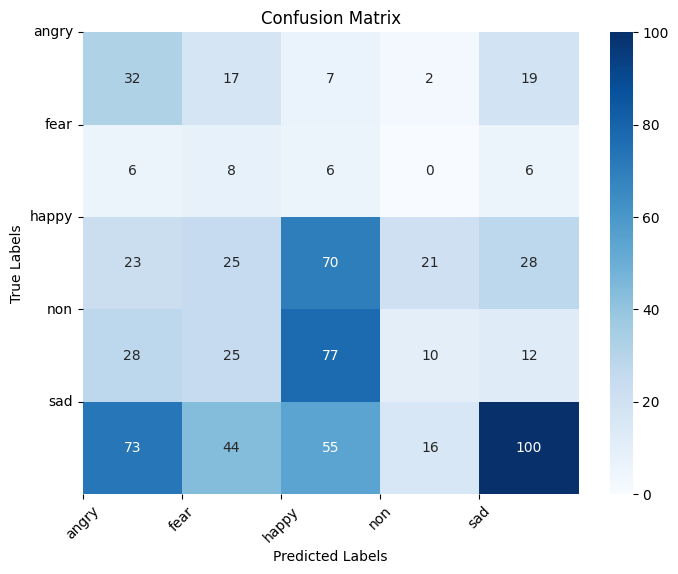

In [ ]:


# Calculate the confusion matrix
cmF2 = confusion_matrix(true_labels, predicted_labelsF2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmF2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportF2 = classification_report(true_labels, predicted_labelsF2, target_names = class_names)

# Print the classification report
print(reportF2)


              precision    recall  f1-score   support

       angry       0.20      0.42      0.27        77
        fear       0.07      0.31      0.11        26
       happy       0.33      0.42      0.37       167
         non       0.20      0.07      0.10       152
         sad       0.61      0.35      0.44       288

    accuracy                           0.31       710
   macro avg       0.28      0.31      0.26       710
weighted avg       0.39      0.31      0.32       710



## RNN-GRU Model Training

#### Lyrics Embeddings only

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

modelE = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_ly], input_length=max_length, trainable=False)
modelE.add(e)
modelE.add(GRU(64, return_sequences=True))  # GRU layer
modelE.add(GRU(64))  # GRU layer
modelE.add(Dense(5, activation='softmax'))  # softmax activation

# compile the model
modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
print(modelE.summary())
modelE.fit(feature_train, label_train, epochs=50, batch_size=32)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 924, 300)          10905900  
                                                                 
 gru_4 (GRU)                 (None, 924, 64)           70272     
                                                                 
 gru_5 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,001,457
Trainable params: 95,557
Non-trainable params: 10,905,900
_________________________________________________________________
None
Epoch 1/50
89/89 [==============================] - 9s 53ms/step - loss: 1.4192 - accuracy: 0.3941
Epoch 2/50
89/89 [==============================] - 4s 47ms/step 

In [ ]:
# model evaluation
loss, accuracy = modelE.evaluate(feature_test, np.array(label_test), verbose=0)
print('Accuracy: %f' % (accuracy * 100))
print('Loss: %f' % loss)

Accuracy: 40.563381
Loss: 1.401016


In [ ]:
# Make predictions

predictions = modelE.predict(feature_test)
predicted_labels = np.argmax(predictions, axis=1)

23/23 [==============================] - 3s 42ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:
for label, word in zip(unique_labels, words):
    print(f"Numerical label: {label}, Word: {word}")

Numerical label: 0, Word: angry
Numerical label: 1, Word: fear
Numerical label: 2, Word: happy
Numerical label: 3, Word: non
Numerical label: 4, Word: sad


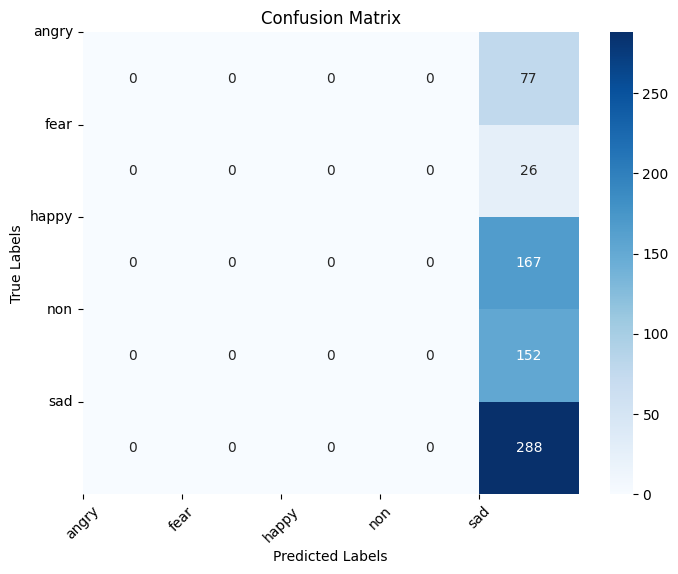

In [ ]:


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['angry','fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportE = classification_report(true_labels, predicted_labels, target_names = class_names)

# Print the classification report
print(reportE)


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        77
        fear       0.00      0.00      0.00        26
       happy       0.00      0.00      0.00       167
         non       0.00      0.00      0.00       152
         sad       0.41      1.00      0.58       288

    accuracy                           0.41       710
   macro avg       0.08      0.20      0.12       710
weighted avg       0.16      0.41      0.23       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CKIP Embeddings only

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

modelE = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
modelE.add(e)
modelE.add(GRU(64, return_sequences=True))  # GRU layer
modelE.add(GRU(64))  # GRU layer
modelE.add(Dense(5, activation='softmax'))  # softmax activation

# compile the model
modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
print(modelE.summary())
modelE.fit(feature_train, label_train, epochs=50, batch_size=32)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 924, 300)          10905900  
                                                                 
 gru (GRU)                   (None, 924, 64)           70272     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 11,001,457
Trainable params: 95,557
Non-trainable params: 10,905,900
_________________________________________________________________
None
Epoch 1/50
89/89 [==============================] - 10s 56ms/step - loss: 1.4257 - accuracy: 0.3962
Epoch 2/50
89/89 [==============================] - 4s 47ms/step -

In [ ]:
# model evaluation
loss, accuracy = modelE.evaluate(feature_test, np.array(label_test), verbose=0)
print('Accuracy: %f' % (accuracy * 100))
print('Loss: %f' % loss)

Accuracy: 40.563381
Loss: 1.399488


In [ ]:
# Make predictions

predictions = modelE.predict(feature_test)
predicted_labels = np.argmax(predictions, axis=1)

23/23 [==============================] - 3s 44ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

In [ ]:
for label, word in zip(unique_labels, words):
    print(f"Numerical label: {label}, Word: {word}")

Numerical label: 0, Word: angry
Numerical label: 1, Word: fear
Numerical label: 2, Word: happy
Numerical label: 3, Word: non
Numerical label: 4, Word: sad


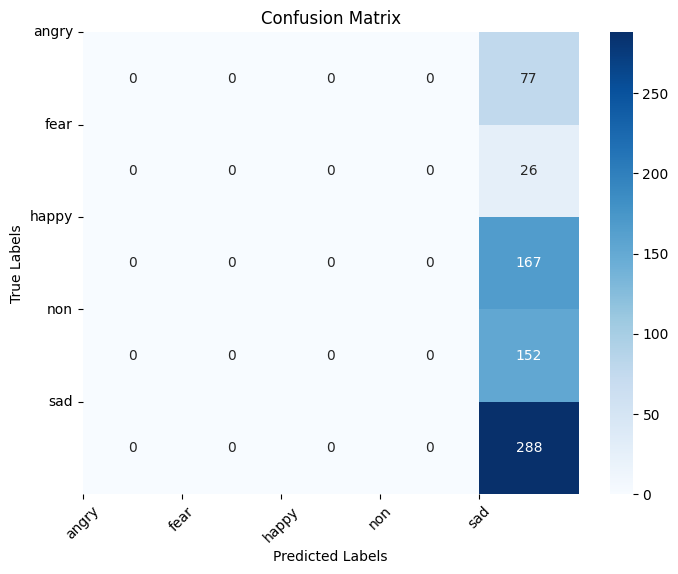

In [ ]:


# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['angry','fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportE = classification_report(true_labels, predicted_labels, target_names = class_names)

# Print the classification report
print(reportE)


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        77
        fear       0.00      0.00      0.00        26
       happy       0.00      0.00      0.00       167
         non       0.00      0.00      0.00       152
         sad       0.41      1.00      0.58       288

    accuracy                           0.41       710
   macro avg       0.08      0.20      0.12       710
weighted avg       0.16      0.41      0.23       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CKIP Embeddings with features

#### BiRNN-GRU with all features

In [ ]:

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model


text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(15,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG = Bidirectional(GRU(64))(layer)  # Replace LSTM with GRU
layer = concatenate([modelG, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = Bidirectional(GRU(64))(layer)  # Replace LSTM with GRU
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          140544      ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 15)]         0           []                               
                                                                                              

In [ ]:
modelgru.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 313s 3s/step - loss: 1.4280 - accuracy: 0.3980
Epoch 2/50
89/89 [==============================] - 296s 3s/step - loss: 1.3902 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 287s 3s/step - loss: 1.3859 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 292s 3s/step - loss: 1.3631 - accuracy: 0.4089
Epoch 5/50
89/89 [==============================] - 288s 3s/step - loss: 1.1744 - accuracy: 0.5319
Epoch 6/50
89/89 [==============================] - 290s 3s/step - loss: 0.8882 - accuracy: 0.6496
Epoch 7/50
89/89 [==============================] - 292s 3s/step - loss: 0.5868 - accuracy: 0.7751
Epoch 8/50
89/89 [==============================] - 293s 3s/step - loss: 0.3599 - accuracy: 0.8639
Epoch 9/50
89/89 [==============================] - 284s 3s/step - loss: 0.2772 - accuracy: 0.9020
Epoch 10/50
89/89 [==============================] - 288s 3s/step - loss: 0.2000 - accuracy: 0.9267
Epoch 11/

In [ ]:

# Evaluate the model
loss, accuracy = modelgru.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 25.35%
Loss: 9.5768


In [ ]:
# Make predictions

predictionsG = modelgru.predict([feature_test, adfeature_test])
predicted_labelsG = np.argmax(predictionsG, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 17s 651ms/step


In [ ]:
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

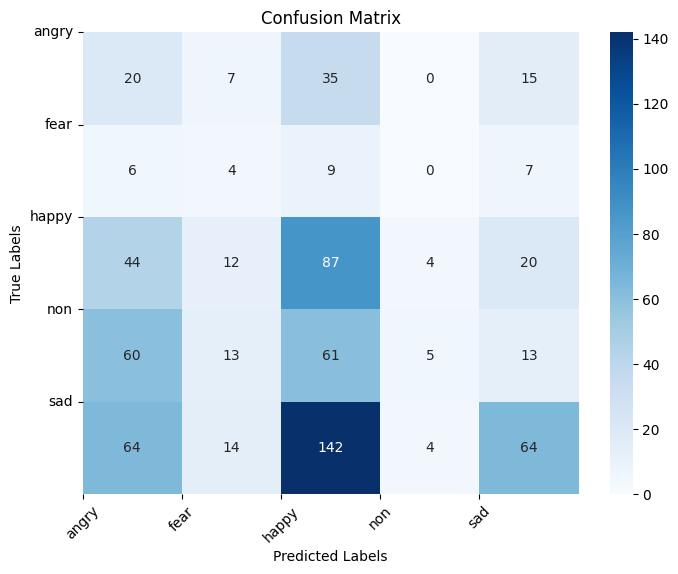

In [ ]:


# Calculate the confusion matrix
cmG = confusion_matrix(true_labels, predicted_labelsG)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG = classification_report(true_labels, predicted_labelsG, target_names = class_names)

# Print the classification report
print(reportG)


              precision    recall  f1-score   support

       angry       0.10      0.26      0.15        77
        fear       0.08      0.15      0.11        26
       happy       0.26      0.52      0.35       167
         non       0.38      0.03      0.06       152
         sad       0.54      0.22      0.31       288

    accuracy                           0.25       710
   macro avg       0.27      0.24      0.20       710
weighted avg       0.38      0.25      0.24       710



#### RNN-GRU with all features

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(15,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru (GRU)                      (None, 64)           70272       ['embedding[0][0]']              
                                                                                                  
 feature (InputLayer)           [(None, 15)]         0           []                               
                                                                                              

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 65s 556ms/step - loss: 1.4410 - accuracy: 0.3920
Epoch 2/50
89/89 [==============================] - 44s 498ms/step - loss: 1.3899 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 27s 303ms/step - loss: 1.3843 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 16s 181ms/step - loss: 1.3875 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 15s 169ms/step - loss: 1.3858 - accuracy: 0.3987
Epoch 6/50
89/89 [==============================] - 13s 142ms/step - loss: 1.3847 - accuracy: 0.3987
Epoch 7/50
89/89 [==============================] - 13s 143ms/step - loss: 1.3788 - accuracy: 0.3994
Epoch 8/50
89/89 [==============================] - 11s 125ms/step - loss: 1.3731 - accuracy: 0.4011
Epoch 9/50
89/89 [==============================] - 11s 127ms/step - loss: 1.3697 - accuracy: 0.4029
Epoch 10/50
89/89 [==============================] - 9s 100ms/step - loss: 1.3661 - accurac

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 47.18%
Loss: 1.2661


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 20ms/step


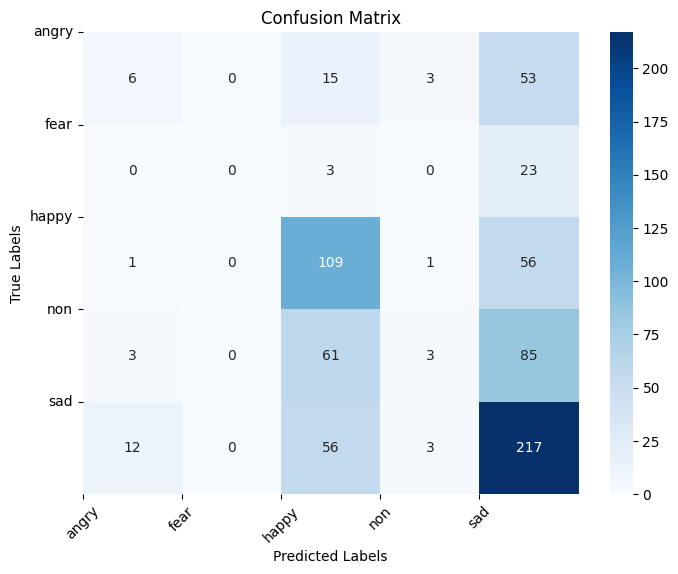

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.27      0.08      0.12        77
        fear       0.00      0.00      0.00        26
       happy       0.45      0.65      0.53       167
         non       0.30      0.02      0.04       152
         sad       0.50      0.75      0.60       288

    accuracy                           0.47       710
   macro avg       0.30      0.30      0.26       710
weighted avg       0.40      0.47      0.39       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+first_single+third_single+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(4,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_2 (GRU)                    (None, 64)           70272       ['embedding_2[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 4)]          0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 36s 322ms/step - loss: 1.4346 - accuracy: 0.3980
Epoch 2/50
89/89 [==============================] - 27s 304ms/step - loss: 1.3904 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 13s 145ms/step - loss: 1.3904 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 12s 138ms/step - loss: 1.3877 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 10s 117ms/step - loss: 1.3873 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 9s 102ms/step - loss: 1.3857 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 11s 123ms/step - loss: 1.3858 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 8s 96ms/step - loss: 1.3834 - accuracy: 0.3976
Epoch 9/50
89/89 [==============================] - 8s 84ms/step - loss: 1.3839 - accuracy: 0.3990
Epoch 10/50
89/89 [==============================] - 8s 95ms/step - loss: 1.3796 - accuracy: 0.3

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 43.24%
Loss: 1.3556


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 12ms/step


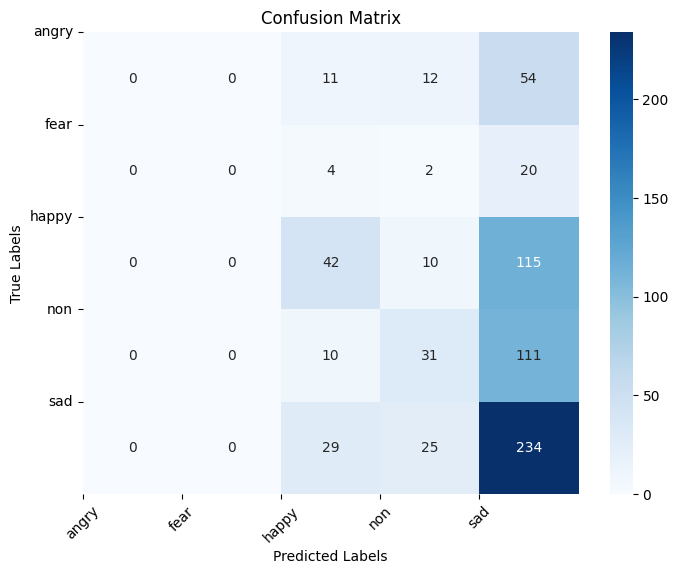

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        77
        fear       0.00      0.00      0.00        26
       happy       0.44      0.25      0.32       167
         non       0.39      0.20      0.27       152
         sad       0.44      0.81      0.57       288

    accuracy                           0.43       710
   macro avg       0.25      0.25      0.23       710
weighted avg       0.36      0.43      0.36       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(6,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_10 (GRU)                   (None, 64)           70272       ['embedding_5[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 6)]          0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 37s 323ms/step - loss: 1.4275 - accuracy: 0.3962
Epoch 2/50
89/89 [==============================] - 16s 174ms/step - loss: 1.3916 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 12s 134ms/step - loss: 1.3906 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 13s 148ms/step - loss: 1.3889 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 10s 108ms/step - loss: 1.3893 - accuracy: 0.3976
Epoch 6/50
89/89 [==============================] - 10s 110ms/step - loss: 1.3855 - accuracy: 0.3987
Epoch 7/50
89/89 [==============================] - 11s 120ms/step - loss: 1.3846 - accuracy: 0.3987
Epoch 8/50
89/89 [==============================] - 10s 108ms/step - loss: 1.3817 - accuracy: 0.3994
Epoch 9/50
89/89 [==============================] - 8s 87ms/step - loss: 1.3779 - accuracy: 0.3990
Epoch 10/50
89/89 [==============================] - 7s 80ms/step - loss: 1.3760 - accuracy: 

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 49.01%
Loss: 1.2662


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 12ms/step


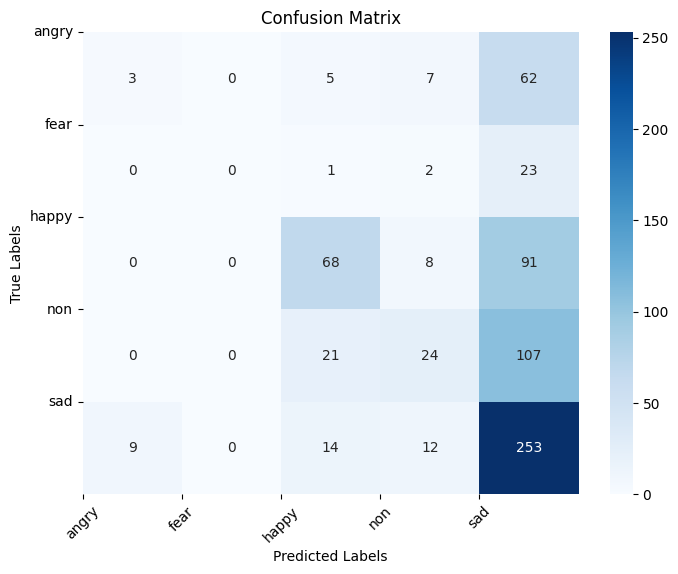

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.25      0.04      0.07        77
        fear       0.00      0.00      0.00        26
       happy       0.62      0.41      0.49       167
         non       0.45      0.16      0.23       152
         sad       0.47      0.88      0.61       288

    accuracy                           0.49       710
   macro avg       0.36      0.30      0.28       710
weighted avg       0.46      0.49      0.42       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+hyper+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(7,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_14 (GRU)                   (None, 64)           70272       ['embedding_7[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 7)]          0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 37s 324ms/step - loss: 1.4473 - accuracy: 0.3927
Epoch 2/50
89/89 [==============================] - 19s 210ms/step - loss: 1.3912 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 13s 145ms/step - loss: 1.3895 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 13s 139ms/step - loss: 1.3884 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 10s 112ms/step - loss: 1.3882 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 11s 126ms/step - loss: 1.3892 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 9s 97ms/step - loss: 1.3869 - accuracy: 0.3990
Epoch 8/50
89/89 [==============================] - 7s 77ms/step - loss: 1.3846 - accuracy: 0.3987
Epoch 9/50
89/89 [==============================] - 8s 87ms/step - loss: 1.3858 - accuracy: 0.3994
Epoch 10/50
89/89 [==============================] - 5s 58ms/step - loss: 1.3847 - accuracy: 0.40

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 50.56%
Loss: 1.2559


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 2s 21ms/step


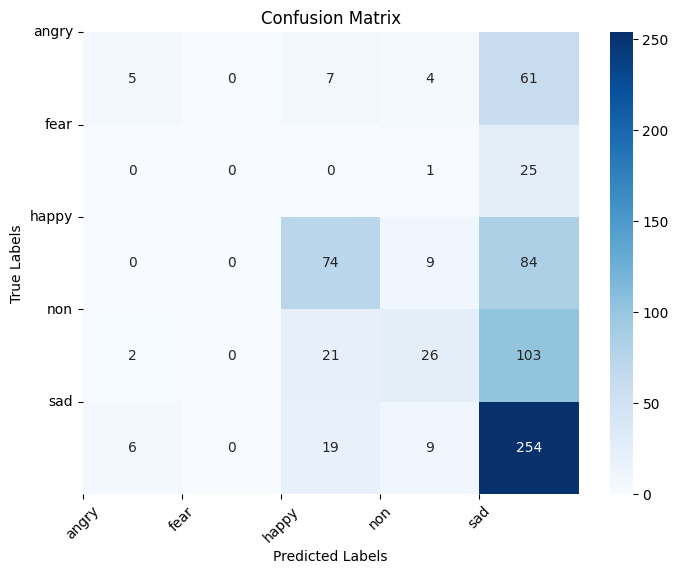

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.38      0.06      0.11        77
        fear       0.00      0.00      0.00        26
       happy       0.61      0.44      0.51       167
         non       0.53      0.17      0.26       152
         sad       0.48      0.88      0.62       288

    accuracy                           0.51       710
   macro avg       0.40      0.31      0.30       710
weighted avg       0.49      0.51      0.44       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+hyper+entropy+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(8,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_2 (GRU)                    (None, 64)           70272       ['embedding_1[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 8)]          0           []                               
                                                                                              

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 34s 302ms/step - loss: 1.4485 - accuracy: 0.3683
Epoch 2/50
89/89 [==============================] - 19s 218ms/step - loss: 1.3951 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 19s 207ms/step - loss: 1.3910 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 15s 175ms/step - loss: 1.3918 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 15s 162ms/step - loss: 1.3874 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 13s 149ms/step - loss: 1.3881 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 13s 144ms/step - loss: 1.3871 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 10s 110ms/step - loss: 1.3873 - accuracy: 0.3994
Epoch 9/50
89/89 [==============================] - 8s 92ms/step - loss: 1.3855 - accuracy: 0.4001
Epoch 10/50
89/89 [==============================] - 8s 93ms/step - loss: 1.3846 - accuracy: 

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 50.99%
Loss: 1.2557


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 13ms/step


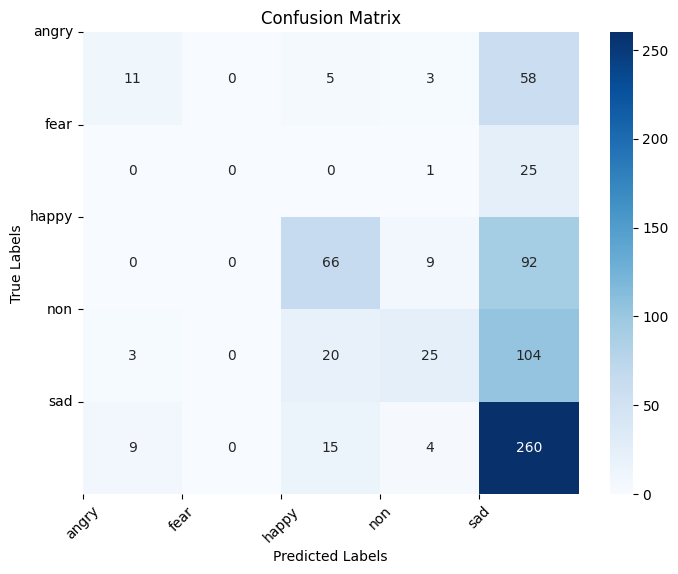

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.48      0.14      0.22        77
        fear       0.00      0.00      0.00        26
       happy       0.62      0.40      0.48       167
         non       0.60      0.16      0.26       152
         sad       0.48      0.90      0.63       288

    accuracy                           0.51       710
   macro avg       0.44      0.32      0.32       710
weighted avg       0.52      0.51      0.45       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+hyper+length+entropy+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(9,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_4 (GRU)                    (None, 64)           70272       ['embedding_2[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 9)]          0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 36s 331ms/step - loss: 1.4294 - accuracy: 0.3955
Epoch 2/50
89/89 [==============================] - 21s 236ms/step - loss: 1.3938 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 13s 150ms/step - loss: 1.3901 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 12s 133ms/step - loss: 1.3890 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 12s 128ms/step - loss: 1.3879 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 11s 120ms/step - loss: 1.3896 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 9s 101ms/step - loss: 1.3879 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 8s 83ms/step - loss: 1.3895 - accuracy: 0.3980
Epoch 9/50
89/89 [==============================] - 9s 99ms/step - loss: 1.3855 - accuracy: 0.3980
Epoch 10/50
89/89 [==============================] - 4s 50ms/step - loss: 1.3829 - accuracy: 0.3

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 51.55%
Loss: 1.2501


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 13ms/step


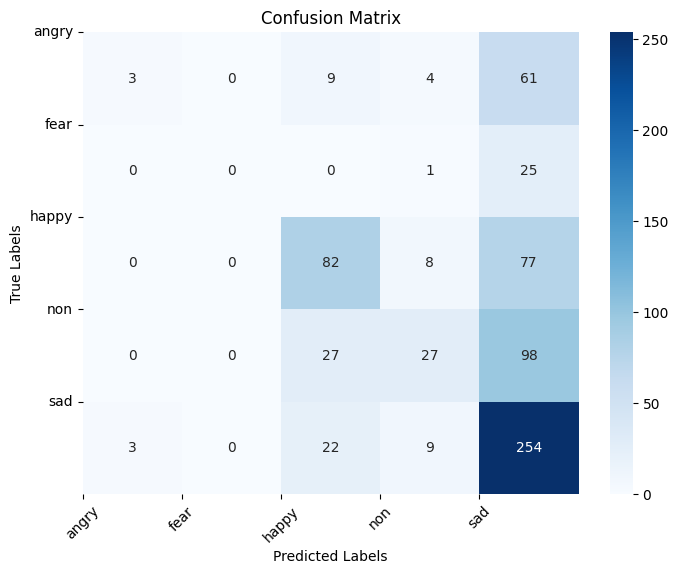

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.50      0.04      0.07        77
        fear       0.00      0.00      0.00        26
       happy       0.59      0.49      0.53       167
         non       0.55      0.18      0.27       152
         sad       0.49      0.88      0.63       288

    accuracy                           0.52       710
   macro avg       0.43      0.32      0.30       710
weighted avg       0.51      0.52      0.45       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+hyper+length+escape+entropy+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(10,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_6 (GRU)                    (None, 64)           70272       ['embedding_3[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 10)]         0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 36s 317ms/step - loss: 1.4443 - accuracy: 0.3958
Epoch 2/50
89/89 [==============================] - 17s 190ms/step - loss: 1.3924 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 13s 151ms/step - loss: 1.3903 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 12s 134ms/step - loss: 1.3915 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 12s 140ms/step - loss: 1.3918 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 10s 117ms/step - loss: 1.3887 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 8s 92ms/step - loss: 1.3875 - accuracy: 0.3980
Epoch 8/50
89/89 [==============================] - 9s 97ms/step - loss: 1.3870 - accuracy: 0.3976
Epoch 9/50
89/89 [==============================] - 6s 67ms/step - loss: 1.3860 - accuracy: 0.3983
Epoch 10/50
89/89 [==============================] - 7s 82ms/step - loss: 1.3847 - accuracy: 0.39

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 52.25%
Loss: 1.2506


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 12ms/step


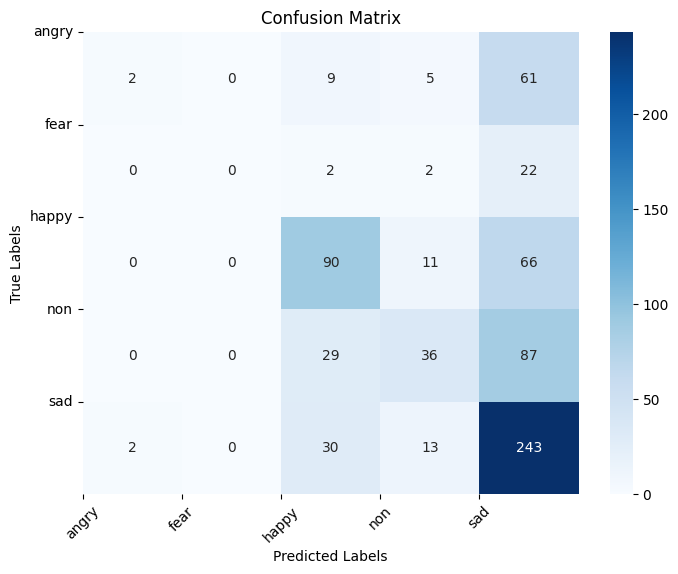

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.50      0.03      0.05        77
        fear       0.00      0.00      0.00        26
       happy       0.56      0.54      0.55       167
         non       0.54      0.24      0.33       152
         sad       0.51      0.84      0.63       288

    accuracy                           0.52       710
   macro avg       0.42      0.33      0.31       710
weighted avg       0.51      0.52      0.46       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Lyrics Embeddings with features

#### RNN-GRU with all features

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(15,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix_ly], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_8 (GRU)                    (None, 64)           70272       ['embedding_5[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 15)]         0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 47s 416ms/step - loss: 1.4345 - accuracy: 0.3948
Epoch 2/50
89/89 [==============================] - 25s 282ms/step - loss: 1.3908 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 20s 227ms/step - loss: 1.3878 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 21s 234ms/step - loss: 1.3897 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 19s 199ms/step - loss: 1.3841 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 17s 190ms/step - loss: 1.3799 - accuracy: 0.3983
Epoch 7/50
89/89 [==============================] - 14s 163ms/step - loss: 1.3761 - accuracy: 0.3997
Epoch 8/50
89/89 [==============================] - 10s 117ms/step - loss: 1.3684 - accuracy: 0.4001
Epoch 9/50
89/89 [==============================] - 9s 98ms/step - loss: 1.3690 - accuracy: 0.3997
Epoch 10/50
89/89 [==============================] - 8s 84ms/step - loss: 1.3679 - accuracy: 

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 48.59%
Loss: 1.2563


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 13ms/step


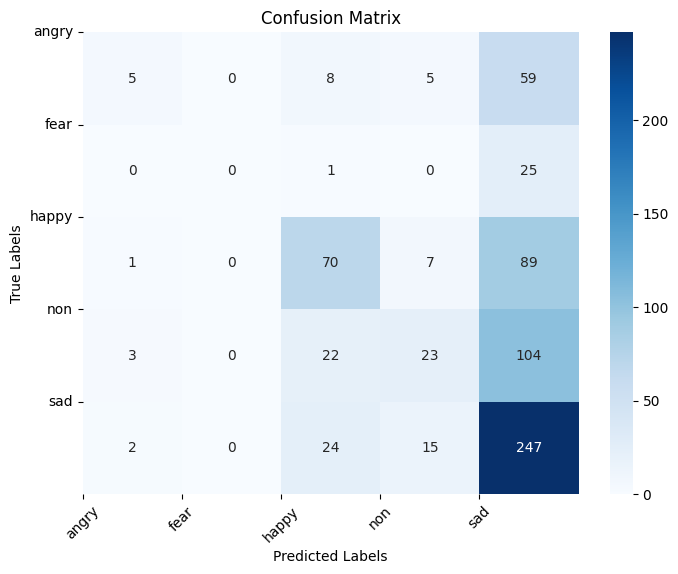

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.45      0.06      0.11        77
        fear       0.00      0.00      0.00        26
       happy       0.56      0.42      0.48       167
         non       0.46      0.15      0.23       152
         sad       0.47      0.86      0.61       288

    accuracy                           0.49       710
   macro avg       0.39      0.30      0.29       710
weighted avg       0.47      0.49      0.42       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### RNN-GRU positive+negative+hyper+length+escape+entropy+first_plural+third_single+third_plural+code_switch

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model

text_inputs = Input(name='input', shape=[max_length])
feature_input = Input(name='feature', shape=(10,))
input_data = np.array(feature_train)
additional_feature_data = np.array(adfeature_train)
labels = np.array(label_train)
layer = Embedding(vocab_size, 300, weights=[embedding_matrix_ly], input_length=max_length)(text_inputs)
modelG2 = GRU(64)(layer)
layer = concatenate([modelG2, feature_input])
layer = Reshape((layer.shape[1], 1))(layer)
layer = GRU(64)(layer)
layer = Dense(64, activation='relu')(layer)
output = Dense(5, activation='softmax')(layer)
modelgru2 = Model(inputs=[text_inputs, feature_input], outputs=output)
modelgru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 924)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 924, 300)     10905900    ['input[0][0]']                  
                                                                                                  
 gru_10 (GRU)                   (None, 64)           70272       ['embedding_6[0][0]']            
                                                                                                  
 feature (InputLayer)           [(None, 10)]         0           []                               
                                                                                            

In [ ]:
modelgru2.fit([input_data, additional_feature_data], labels, epochs=50, batch_size=32)


Epoch 1/50
89/89 [==============================] - 23s 209ms/step - loss: 1.4385 - accuracy: 0.3902
Epoch 2/50
89/89 [==============================] - 16s 180ms/step - loss: 1.3904 - accuracy: 0.3980
Epoch 3/50
89/89 [==============================] - 14s 159ms/step - loss: 1.3915 - accuracy: 0.3980
Epoch 4/50
89/89 [==============================] - 13s 147ms/step - loss: 1.3898 - accuracy: 0.3980
Epoch 5/50
89/89 [==============================] - 11s 123ms/step - loss: 1.3902 - accuracy: 0.3980
Epoch 6/50
89/89 [==============================] - 8s 93ms/step - loss: 1.3895 - accuracy: 0.3980
Epoch 7/50
89/89 [==============================] - 8s 93ms/step - loss: 1.3875 - accuracy: 0.3976
Epoch 8/50
89/89 [==============================] - 8s 87ms/step - loss: 1.3865 - accuracy: 0.3980
Epoch 9/50
89/89 [==============================] - 7s 84ms/step - loss: 1.3861 - accuracy: 0.3990
Epoch 10/50
89/89 [==============================] - 8s 91ms/step - loss: 1.3846 - accuracy: 0.3990

In [ ]:

# Evaluate the model
loss, accuracy = modelgru2.evaluate([feature_test, adfeature_test], np.array(label_test), verbose=0)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Loss: %.4f' % loss)


Accuracy: 50.85%
Loss: 1.2714


In [ ]:
# Make predictions

predictionsG2 = modelgru2.predict([feature_test, adfeature_test])
predicted_labelsG2 = np.argmax(predictionsG2, axis=1)
true_labels=np.argmax(label_test, axis=1)
# Get the unique numerical labels
unique_labels = np.unique(encoded_labels)

# Get the corresponding human-readable words
words = label_encoder.inverse_transform(unique_labels)

23/23 [==============================] - 1s 13ms/step


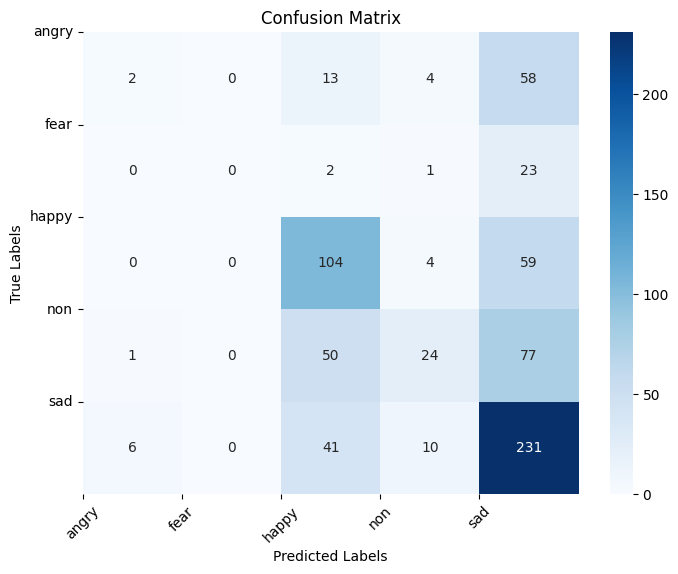

In [ ]:


# Calculate the confusion matrix
cmG2 = confusion_matrix(true_labels, predicted_labelsG2)
class_names = ['angry', 'fear', 'happy', 'non', 'sad']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmG2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(unique_labels)), labels=class_names, rotation=0)
plt.show()
plt.show()


In [ ]:

# Generate the classification report
reportG2 = classification_report(true_labels, predicted_labelsG2, target_names = class_names)

# Print the classification report
print(reportG2)


              precision    recall  f1-score   support

       angry       0.22      0.03      0.05        77
        fear       0.00      0.00      0.00        26
       happy       0.50      0.62      0.55       167
         non       0.56      0.16      0.25       152
         sad       0.52      0.80      0.63       288

    accuracy                           0.51       710
   macro avg       0.36      0.32      0.29       710
weighted avg       0.47      0.51      0.44       710



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
